# Проект предсказания сердечного риска у пациента.
### В этом проекте выполняется работа с датасетом и разработка модели машинного обучения, которая в дальнейшем будет применена в интерфейсе для осуществлекния предсказаний. 
### Ход проекта включает:
* исследование датасета
* предобработка данных
* обучение модели
* подготовка предсказания на тестовой выборке

#### Загрузим необходимые библиотеки.

In [1]:
!pip install missingno -q
!pip install phik -q
!pip install imblearn -q
!pip install xgboost -q
!pip install catboost -q
!pip install lightgbm -q

In [2]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import xgboost as xgb
from phik.report import plot_correlation_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (accuracy_score, precision_score,
                            recall_score, f1_score, roc_auc_score,
                            make_scorer, classification_report, 
                            confusion_matrix, precision_recall_curve,
                            ConfusionMatrixDisplay)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (StandardScaler, 
                                 OneHotEncoder, 
                                 OrdinalEncoder,
                                 MinMaxScaler)
from sklearn.ensemble import (RandomForestClassifier, 
                             GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from catboost import CatBoostClassifier
from sklearn.utils import resample
import pickle

## 1. Загрузка данных

In [3]:
heart_train = pd.read_csv('heart_train.csv', index_col=0)
heart_train.sample(10)

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
3782,0.516854,0.542857,0.065078,1.0,0.0,1.0,0.0,0.0,0.322041,2,...,2.0,0.833333,0.0,0.227018,0.048229,0.036512,Male,0.529032,0.232558,762
2093,0.651685,0.471429,0.037580,1.0,0.0,1.0,0.0,1.0,0.782945,1,...,1.0,0.000000,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.360465,156
1067,0.662921,0.964286,0.025665,1.0,0.0,1.0,0.0,1.0,0.740979,1,...,4.0,0.333333,1.0,0.227018,0.048229,0.036512,Male,0.251613,0.476744,209
3153,0.629213,0.767857,0.080660,0.0,1.0,1.0,1.0,0.0,0.060854,0,...,3.0,0.500000,0.0,0.227018,0.048229,0.036512,Male,0.219355,0.697674,8592
4965,0.853933,0.121429,0.024748,0.0,0.0,1.0,1.0,1.0,0.780822,1,...,5.0,0.000000,0.0,0.227018,0.048229,0.036512,Male,0.309677,0.453488,7172
650,0.415730,0.514286,0.067828,1.0,0.0,1.0,1.0,1.0,0.779341,2,...,5.0,0.333333,0.0,0.195652,0.168744,0.171764,Female,0.645161,0.383721,6260
7461,0.235955,0.585714,0.034830,0.0,1.0,1.0,0.0,0.0,0.862557,1,...,3.0,0.166667,0.0,0.227018,0.048229,0.036512,Male,0.174194,0.709302,8440
751,0.382022,0.250000,0.072411,0.0,0.0,1.0,0.0,1.0,0.300407,1,...,2.0,0.833333,1.0,0.227018,0.048229,0.036512,Male,0.361290,0.558140,6531
1758,0.044944,0.435714,0.077910,1.0,1.0,1.0,1.0,0.0,0.311945,1,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.632258,0.569767,7680
6475,0.044944,0.335714,0.043996,0.0,0.0,0.0,0.0,1.0,0.750385,1,...,6.0,0.833333,1.0,0.227018,0.048229,0.036512,Female,0.735484,0.534884,542


In [4]:
heart_train['Income']

0       0.105948
1       0.164217
2       0.598745
3       0.077605
4       0.341960
          ...   
8680    0.412145
8681    0.295875
8682    0.378114
8683    0.554353
8684    0.753330
Name: Income, Length: 8685, dtype: float64

In [5]:
heart_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8685 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8685 non-null   float64
 1   Cholesterol                      8685 non-null   float64
 2   Heart rate                       8685 non-null   float64
 3   Diabetes                         8442 non-null   float64
 4   Family History                   8442 non-null   float64
 5   Smoking                          8442 non-null   float64
 6   Obesity                          8442 non-null   float64
 7   Alcohol Consumption              8442 non-null   float64
 8   Exercise Hours Per Week          8685 non-null   float64
 9   Diet                             8685 non-null   int64  
 10  Previous Heart Problems          8442 non-null   float64
 11  Medication Use                   8442 non-null   float64
 12  Stress Level        

In [6]:
heart_test = pd.read_csv('heart_test.csv', index_col=0)
heart_test.sample(10)

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
819,0.719101,0.514286,0.034830,0.0,1.0,1.0,1.0,0.0,0.525025,2,...,0.487013,2.0,0.166667,0.197628,0.009040,0.010195,Female,0.516129,0.430233,1568
436,0.539326,0.521429,0.031164,1.0,1.0,1.0,0.0,0.0,0.875743,2,...,0.405195,0.0,0.500000,0.227018,0.048229,0.036512,Male,0.264516,0.767442,5505
929,0.640449,0.632143,0.077910,0.0,0.0,1.0,1.0,0.0,0.536229,1,...,0.814286,7.0,0.666667,0.227018,0.048229,0.036512,Male,0.554839,0.709302,9018
138,0.078652,0.746429,0.054079,1.0,1.0,1.0,0.0,1.0,0.982339,1,...,0.455844,2.0,1.000000,0.227018,0.048229,0.036512,Male,0.180645,0.744186,6560
914,0.730337,0.771429,0.032081,1.0,1.0,1.0,0.0,1.0,0.290006,0,...,0.368831,4.0,0.833333,0.227018,0.048229,0.036512,Male,0.161290,0.476744,4054
261,0.146067,0.053571,0.026581,1.0,1.0,0.0,0.0,1.0,0.845560,1,...,0.346753,1.0,1.000000,0.227018,0.048229,0.036512,Female,0.354839,0.406977,80
443,0.089888,0.017857,0.041247,1.0,1.0,0.0,0.0,1.0,0.758794,0,...,0.392208,3.0,0.166667,0.227018,0.048229,0.036512,Female,0.561290,0.732558,4829
891,0.539326,0.257143,0.030247,1.0,1.0,1.0,1.0,1.0,0.517756,1,...,0.723377,6.0,1.000000,0.152174,0.006771,0.117390,Male,0.600000,0.581395,6613
571,0.471910,0.175000,0.077910,0.0,0.0,1.0,0.0,0.0,0.144752,2,...,0.163636,1.0,0.333333,0.227018,0.048229,0.036512,Female,0.593548,0.465116,8636
758,0.550562,0.499780,0.085243,NaN,NaN,NaN,NaN,NaN,0.502110,3,...,0.503603,NaN,0.504621,0.061265,0.019384,0.001165,1.0,0.425806,0.244186,9464


## 2. Предобработка данных

##### Выведем пропуски

<AxesSubplot:>

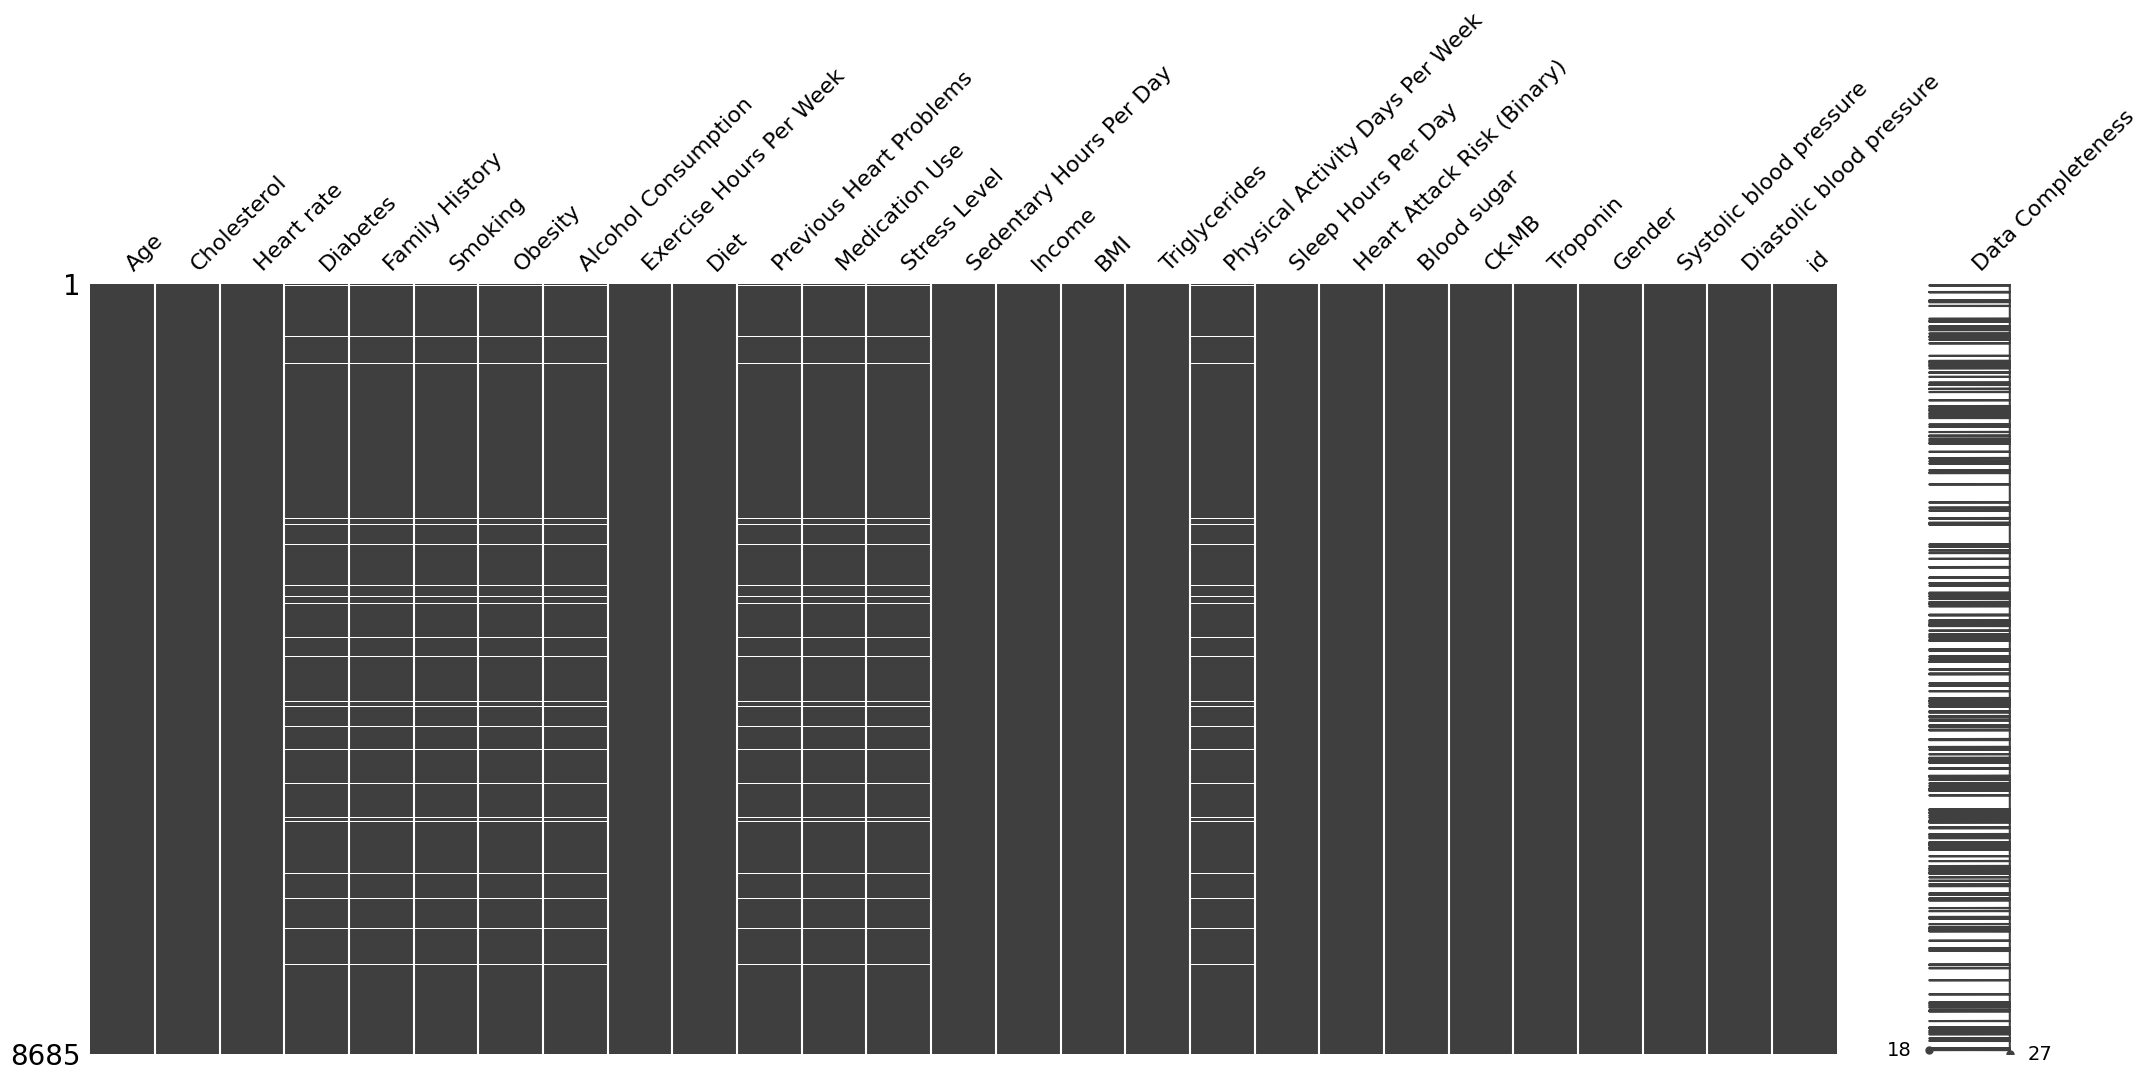

In [7]:
msno.matrix(heart_train, labels=True)

<AxesSubplot:>

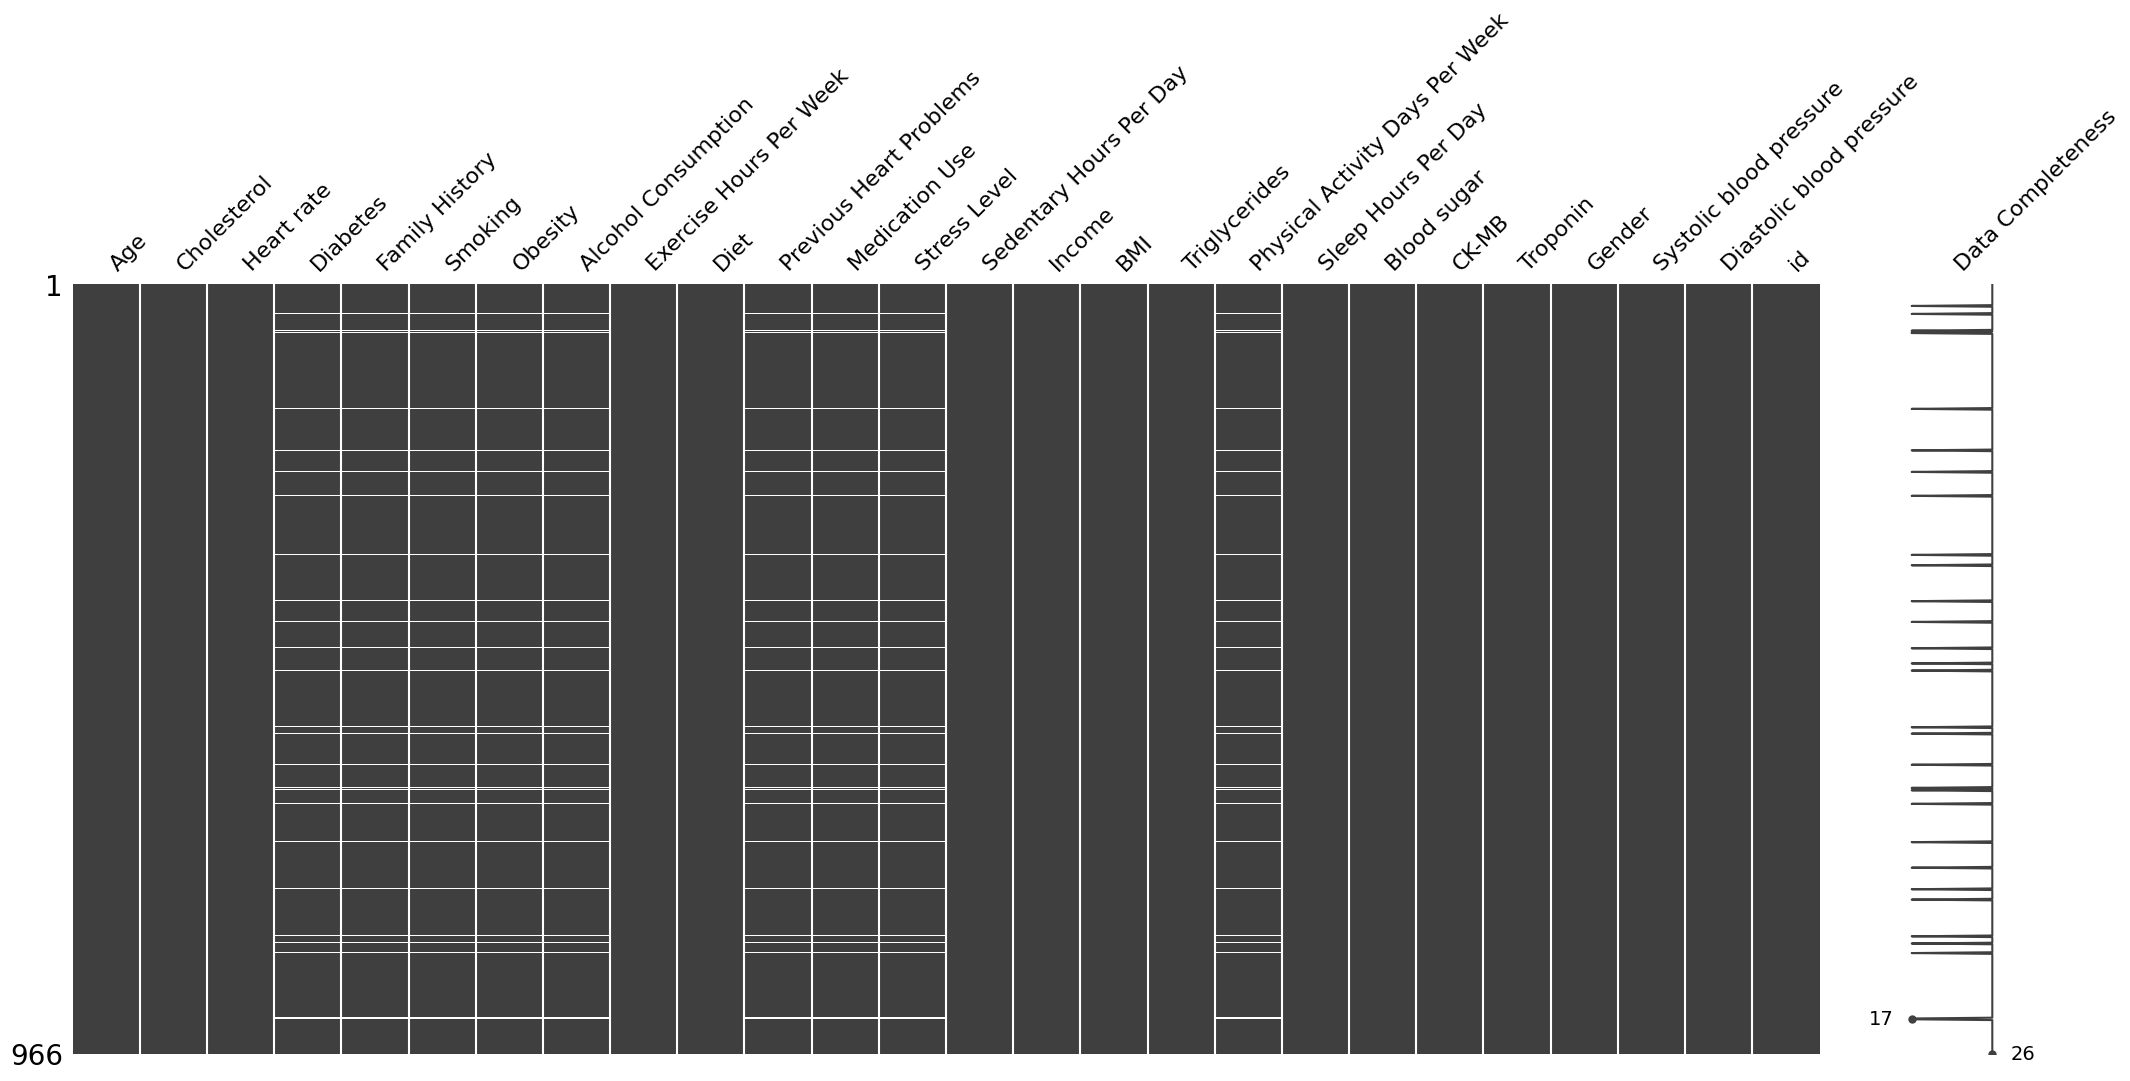

In [8]:
msno.matrix(heart_test, labels=True)

Пропуски только в бинарных столбцах.

Посмотрим какую долю составляют пропуски и что с ними можно сделать.

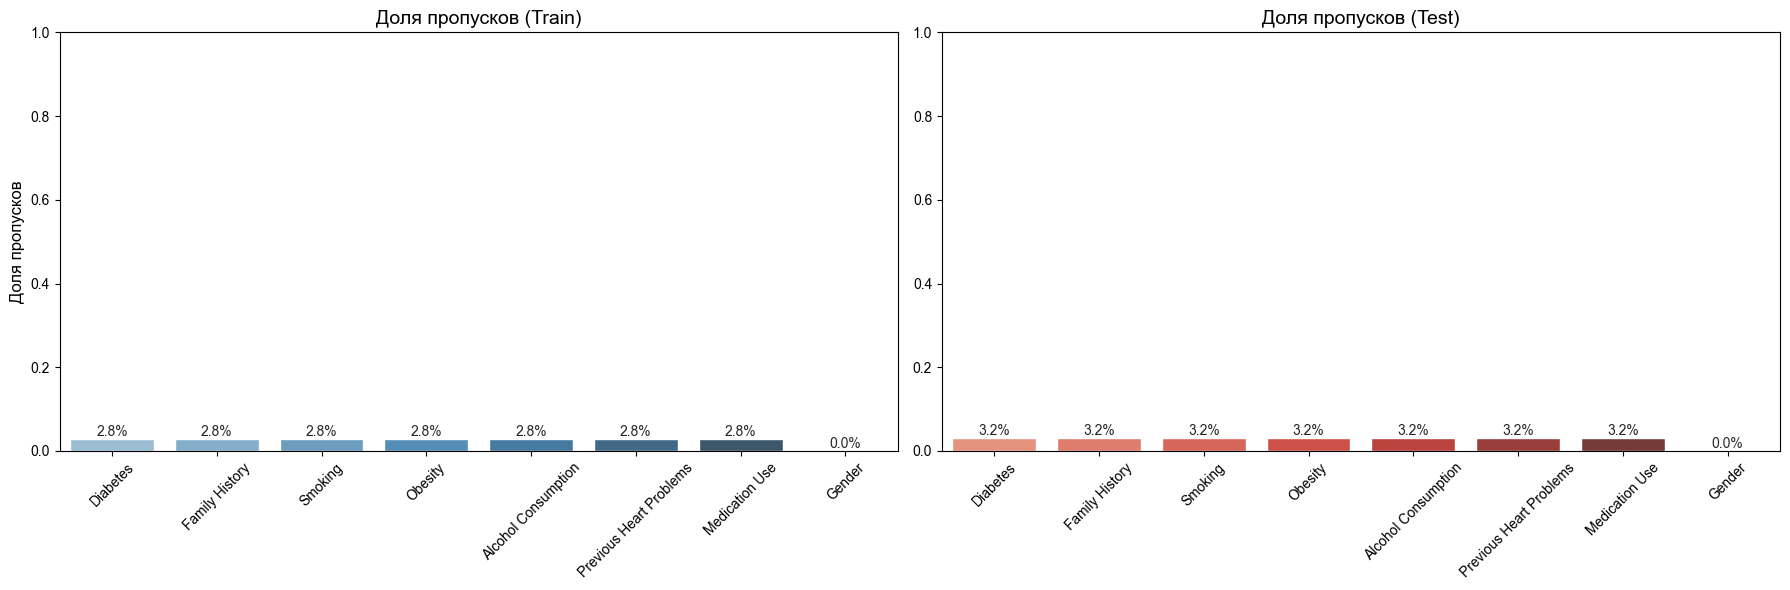

In [9]:
binary_cols = [
    'Diabetes', 'Family History', 'Smoking', 'Obesity',
    'Alcohol Consumption', 'Previous Heart Problems',
    'Medication Use', 'Gender'
]

# Создаем фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.set_style("whitegrid")

# График для train
train_missing = heart_train[binary_cols].isna().mean().sort_values(ascending=False)
sns.barplot(x=train_missing.index, y=train_missing.values, palette="Blues_d", ax=ax1)
ax1.set_title('Доля пропусков (Train)', fontsize=14)
ax1.set_ylabel('Доля пропусков', fontsize=12)
ax1.set_ylim(0, 1)
ax1.tick_params(axis='x', rotation=45)

# График для test
test_missing = heart_test[binary_cols].isna().mean().sort_values(ascending=False)
sns.barplot(x=test_missing.index, y=test_missing.values, palette="Reds_d", ax=ax2)
ax2.set_title('Доля пропусков (Test)', fontsize=14)
ax2.set_ylabel('')  # Убираем дублирующую подпись
ax2.set_ylim(0, 1)
ax2.tick_params(axis='x', rotation=45)

# Добавляем аннотации
for ax in (ax1, ax2):
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():.1%}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center',
            xytext=(0, 5),
            textcoords='offset points'
        )

plt.tight_layout()
plt.show()

Так как процент пропусков у в том и в том датасете мал, то можно от них избавиться.

Перед этим переведем столбец Пол в двоичное представление.

In [10]:
heart_train['Gender'] = heart_train['Gender'].map({'Male': 1, 'Female': 0})
heart_test['Gender'] = heart_test['Gender'].map({'Male': 1, 'Female': 0})

In [11]:
# Выводим количество строк до удаления
print(f"Количество строк в train до удаления: {len(heart_train)}")
print(f"Количество строк в test до удаления: {len(heart_test)}")

# Удаляем строки с пропусками в бинарных колонках
heart_train_cleaned = heart_train.dropna(subset=binary_cols)
heart_test_cleaned = heart_test.dropna(subset=binary_cols)

# Выводим количество строк после удаления
print(f"Количество строк в train после удаления: {len(heart_train_cleaned)}")
print(f"Количество строк в test после удаления: {len(heart_test_cleaned)}")

# Проверяем, что пропусков больше нет
print("\nПроверка пропусков после очистки:")
print("Пропуски в train:", heart_train_cleaned[binary_cols].isna().sum().sum())
print("Пропуски в test:", heart_test_cleaned[binary_cols].isna().sum().sum())

# Выводим сколько строк было удалено
print(f"\nУдалено строк из train: {len(heart_train) - len(heart_train_cleaned)}")
print(f"Удалено строк из test: {len(heart_test) - len(heart_test_cleaned)}")

Количество строк в train до удаления: 8685
Количество строк в test до удаления: 966
Количество строк в train после удаления: 8442
Количество строк в test после удаления: 935

Проверка пропусков после очистки:
Пропуски в train: 0
Пропуски в test: 0

Удалено строк из train: 243
Удалено строк из test: 31


Измненим у бинарных столбцов тип данных с float на int.

In [12]:
heart_train_cleaned.loc[:, binary_cols] = heart_train_cleaned.loc[:, binary_cols].astype(int)
heart_test_cleaned.loc[:, binary_cols] = heart_test_cleaned.loc[:, binary_cols].astype(int)

K:\program\Anaconda\envs\practicum\lib\site-packages\pandas\core\indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


И посмотрим что получилось.

In [13]:
heart_train_cleaned.head()

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0.359551,0.732143,0.074244,1,1,1,1,1,0.535505,1,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,1,0.212903,0.709302,2664
1,0.202247,0.325000,0.047663,1,1,0,0,1,0.068690,2,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,0,0.412903,0.569767,9287
2,0.606742,0.860714,0.055912,1,0,1,1,1,0.944001,2,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,0,0.238710,0.220930,5379
3,0.730337,0.007143,0.053162,0,0,1,0,1,0.697023,0,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,0,0.348387,0.267442,8222
4,0.775281,0.757143,0.021998,0,0,1,0,1,0.412878,1,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,1,0.619355,0.441860,4047


In [14]:
heart_test_cleaned.head()

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0.494382,0.264286,0.062328,0,1,1,1,1,0.361618,2,...,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,1,0.283871,0.372093,7746
1,0.224719,0.953571,0.082493,1,0,0,1,0,0.996483,2,...,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,0,0.703226,0.441860,4202
2,0.629213,0.092857,0.064161,0,1,1,1,0,0.995561,0,...,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,1,0.458065,0.779070,6632
3,0.460674,0.567857,0.055912,1,1,1,1,1,0.437277,0,...,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,0,0.741935,0.255814,4639
4,0.719101,0.485714,0.022915,1,0,1,0,1,0.514920,0,...,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,1,0.412903,0.395349,4825


## 3. Анализ данных

##### Рассмотрим распределение качественных и количественных признаков.

Посмотрим круговые диаграммы для бинарных признаков.

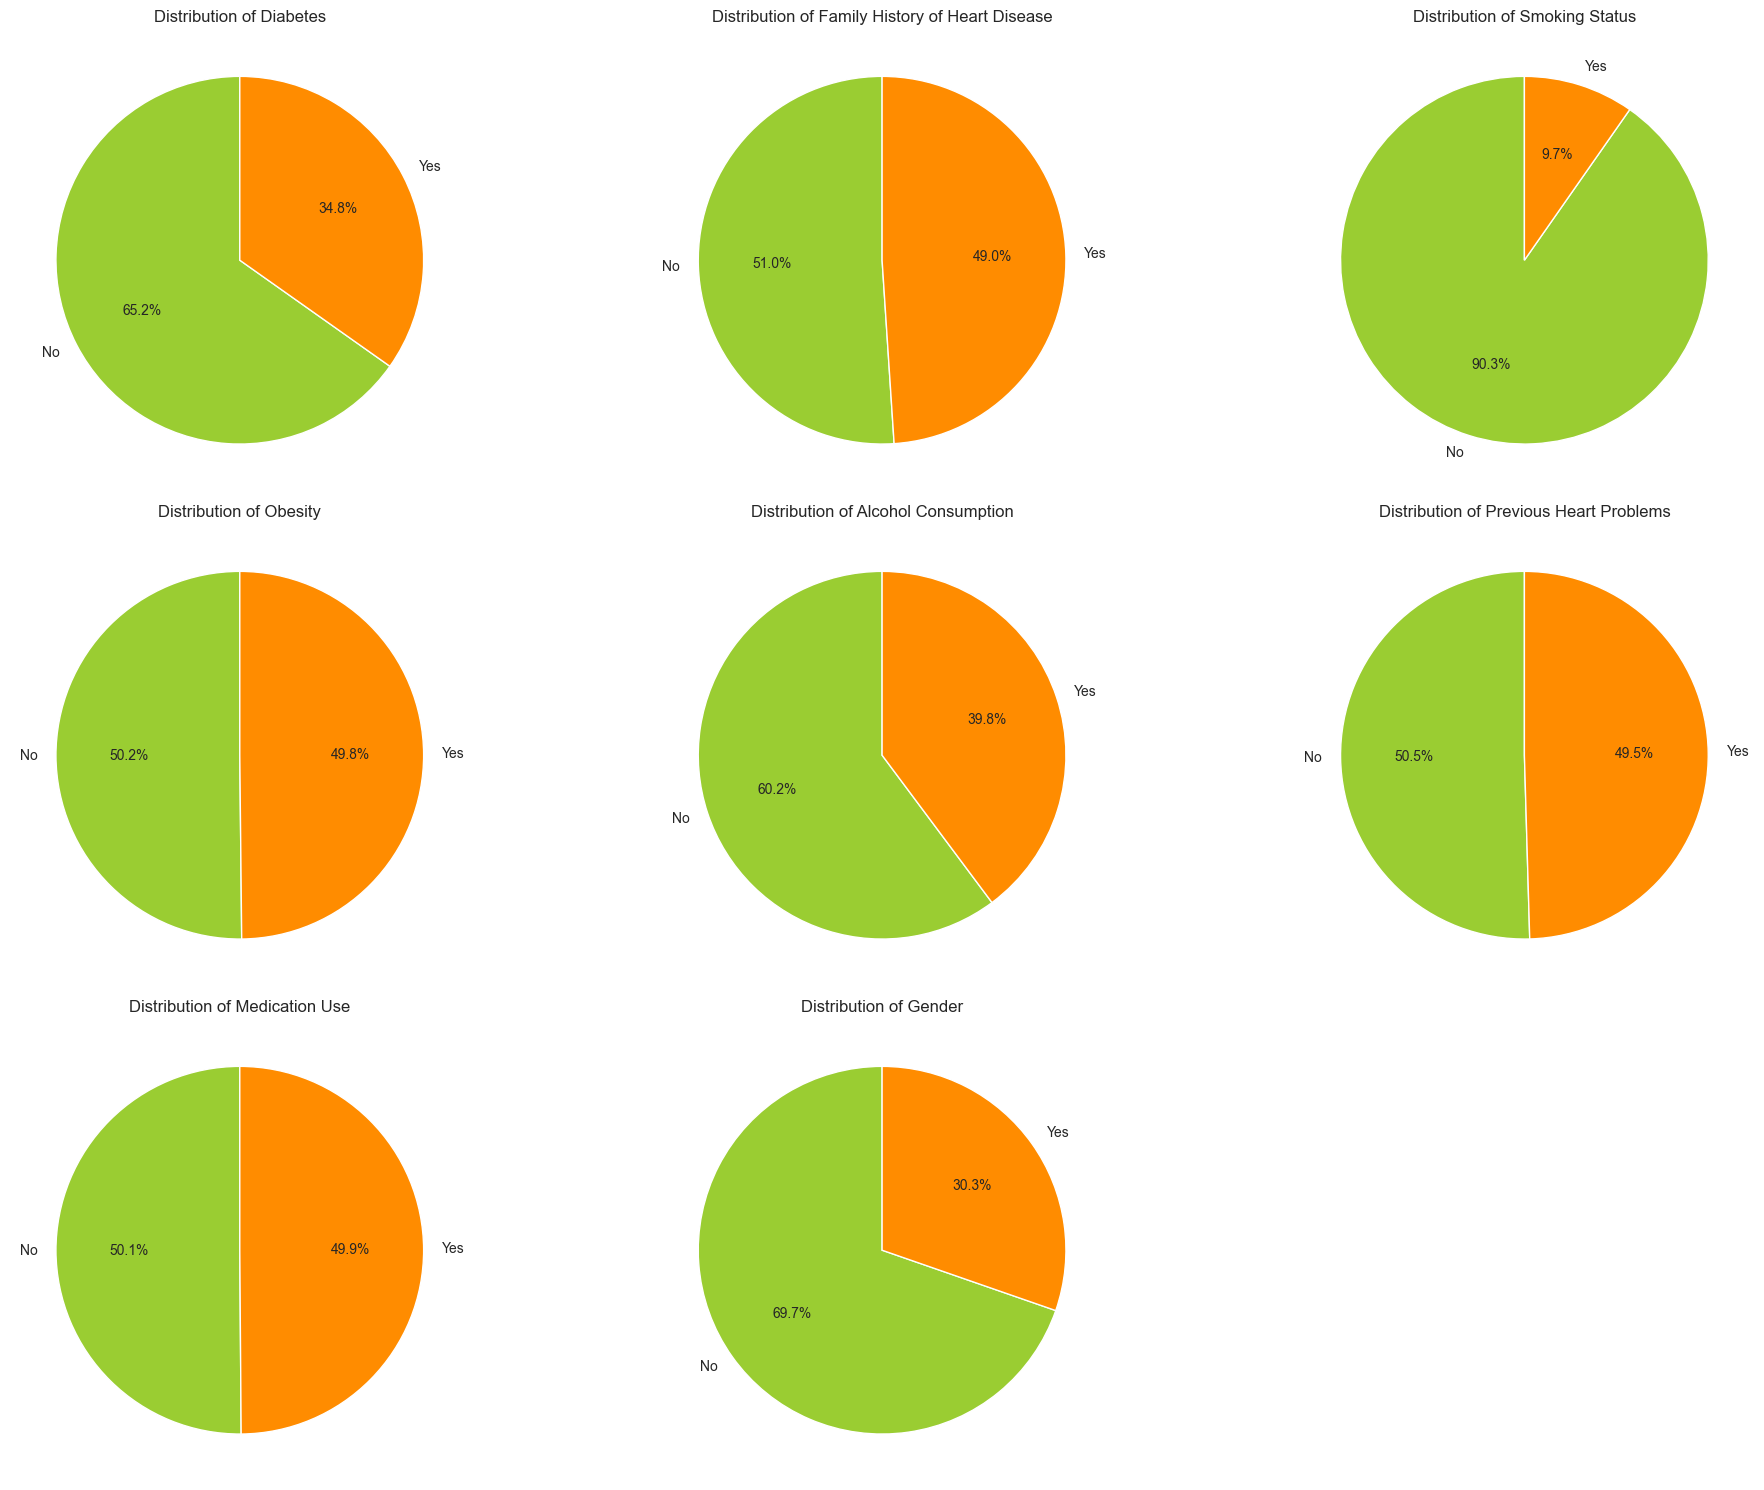

In [15]:
binary_cols = [
    'Diabetes', 'Family History', 'Smoking', 'Obesity',
    'Alcohol Consumption', 'Previous Heart Problems',
    'Medication Use', 'Gender'
]

col_labels = [
    'Diabetes (1 = Yes, 0 = No)',
    'Family History of Heart Disease (1 = Yes, 0 = No)',
    'Smoking Status (1 = Smoker, 0 = Non-smoker)',
    'Obesity (1 = Obese, 0 = Not obese)',
    'Alcohol Consumption (1 = Regular, 0 = Rare/Never)',
    'Previous Heart Problems (1 = Yes, 0 = No)',
    'Medication Use (1 = Yes, 0 = No)',
    'Gender (1 = Male, 0 = Female)'
]

# Настройка сетки графиков
n_cols = 3  # Количество столбцов
n_rows = (len(binary_cols) + n_cols - 1) // n_cols  # Расчет строк

plt.figure(figsize=(20, 5*n_rows))

# Построение круговых диаграмм
for i, (col, label) in enumerate(zip(binary_cols, col_labels), 1):
    plt.subplot(n_rows, n_cols, i)
    
    # Подсчет значений для каждого признака
    counts = heart_train_cleaned[col].value_counts()
    
    # Создание круговой диаграммы
    plt.pie(counts, labels=['No', 'Yes'], autopct='%1.1f%%', startangle=90, colors=['YellowGreen', 'DarkOrange'])
    plt.title(f'Distribution of {label.split("(")[0].strip()}')
    
plt.tight_layout()
plt.show()

Видим следующее:
* больше половины не имеют диабет
* почти все не курят
* половина страдают ожирением
* половина имели проблемы с сердцем в прошлом
* половина прибегали к мед помощи
* больше половины это женщины

Теперь рассмотрим завимость сердечного приступпа от бинарных признаков.

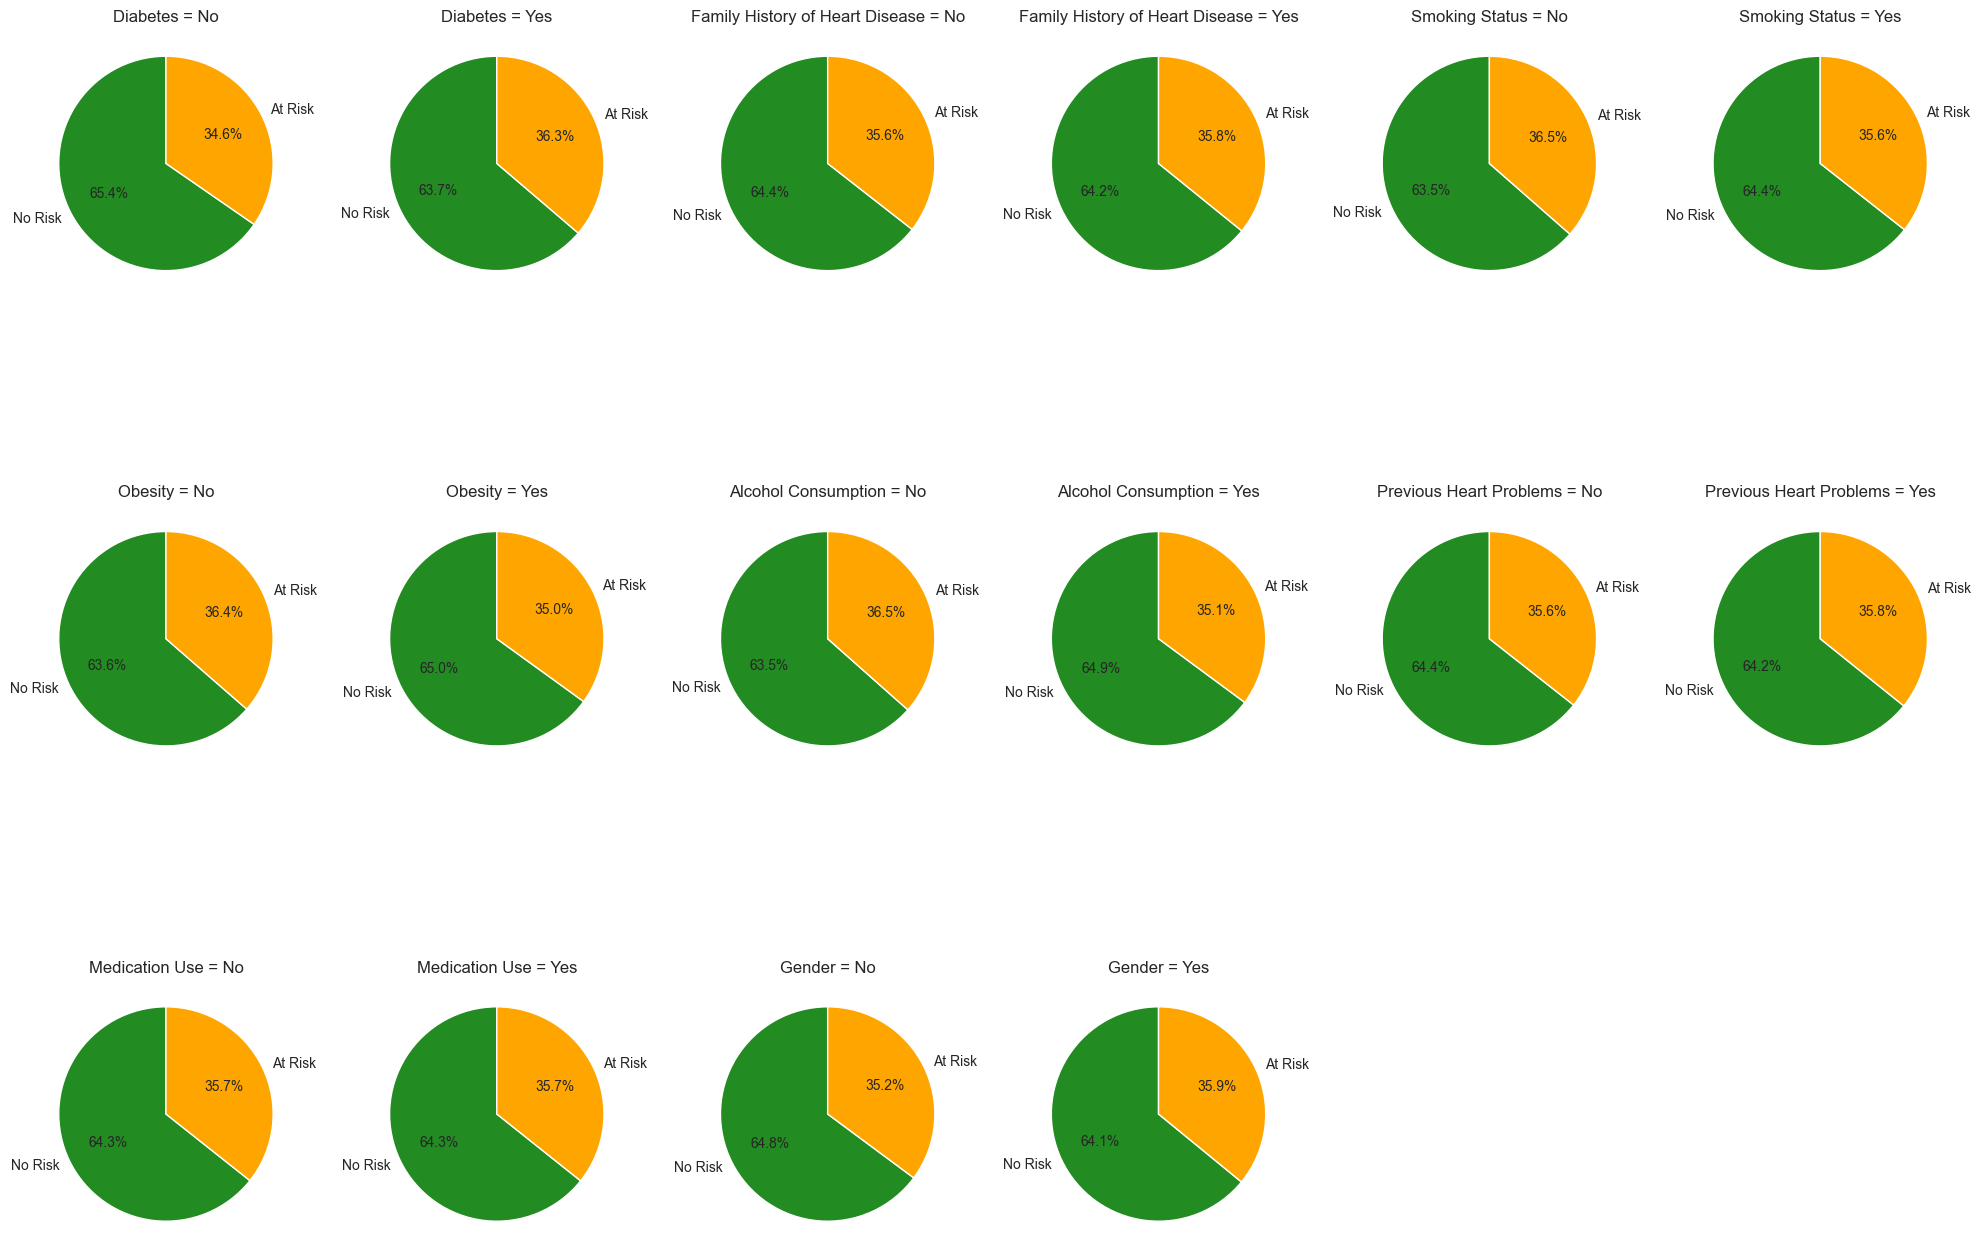

In [16]:
plt.figure(figsize=(20, 5*n_rows))

for i, (col, label) in enumerate(zip(binary_cols, col_labels), 1):
    plt.subplot(n_rows, n_cols, i)
    
    # Группировка данных по признаку и риску сердечного приступа
    grouped = heart_train_cleaned.groupby([col, 'Heart Attack Risk (Binary)']).size().unstack()
    
    # Создание круговой диаграммы для каждой категории
    for j, value in enumerate([0, 1]):
        plt.subplot(n_rows, n_cols*2, i*2 - (1 - j))
        sizes = grouped.loc[value]
        plt.pie(sizes, labels=['No Risk', 'At Risk'], autopct='%1.1f%%', 
                startangle=90, colors=['ForestGreen', 'Orange'])
        plt.title(f'{label.split("(")[0].strip()} = {"No" if value == 0 else "Yes"}')
    
plt.tight_layout()
plt.show()

Явных зависимостей не наблюдается.

Теперь построим диаграммы для количественных признаков.

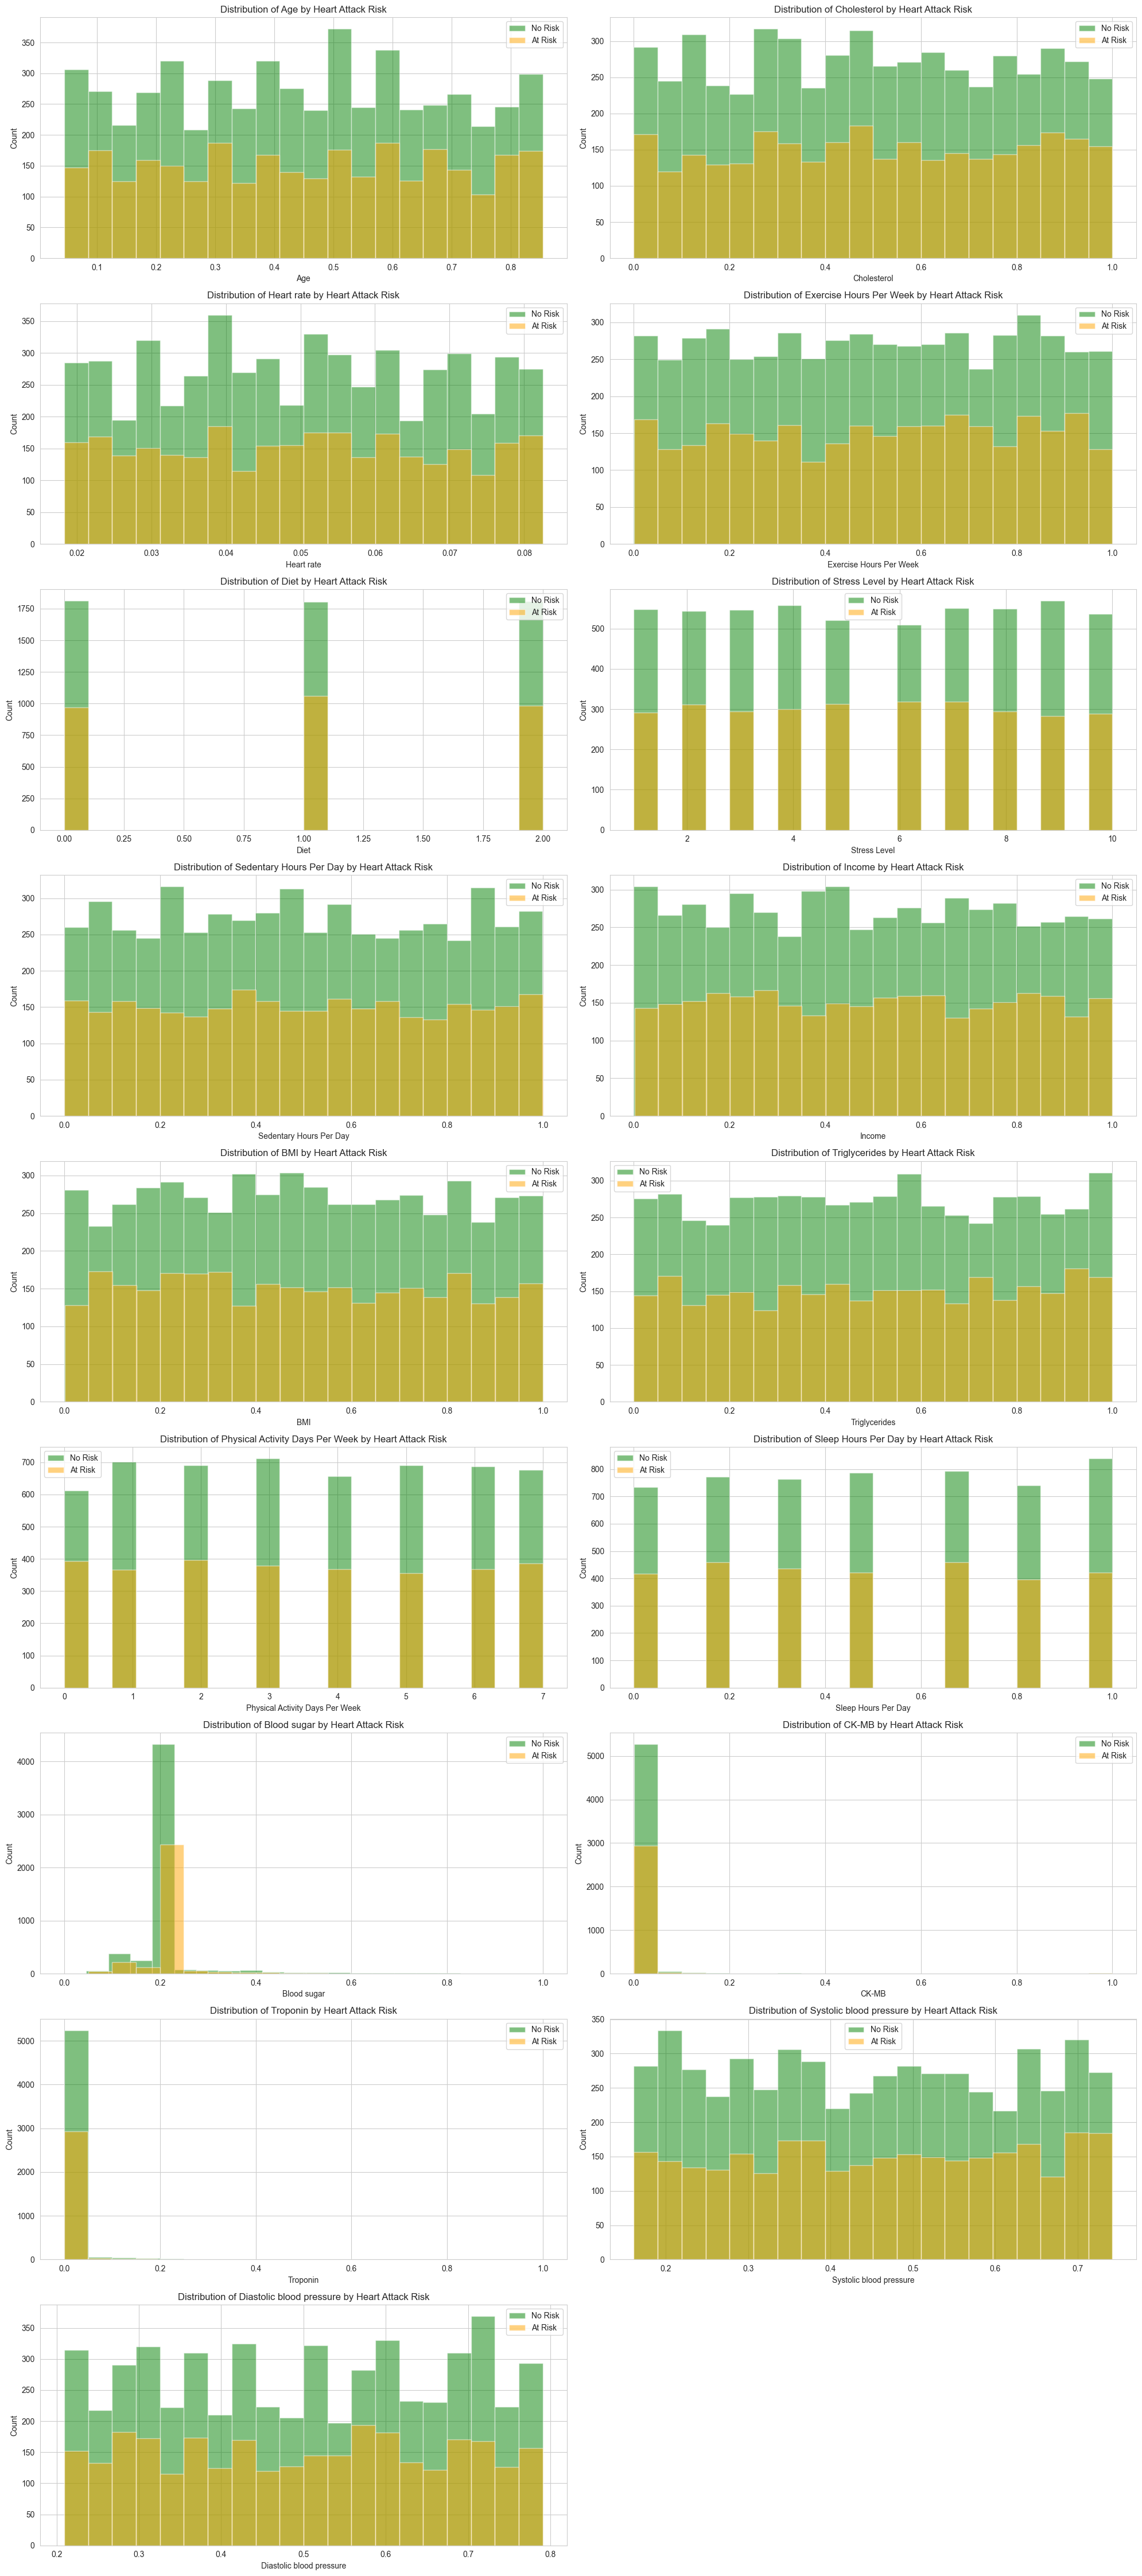

In [17]:
num_cols = [
    'Age', 'Cholesterol', 'Heart rate', 'Exercise Hours Per Week',
    'Diet', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 
    'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 
    'Blood sugar', 'CK-MB', 'Troponin', 'Systolic blood pressure',
    'Diastolic blood pressure'
]

# Настройка сетки графиков - 2 колонки
n_columns = 2
n_rows = math.ceil(len(num_cols) / n_columns)
plt.figure(figsize=(20, 5 * n_rows))
num_bins = 20  # Количество бинов для гистограмм

for i, feature in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_columns, i)
    
    # Разделяем данные по риску сердечного приступа
    no_risk = heart_train_cleaned[heart_train_cleaned['Heart Attack Risk (Binary)'] == 0][feature]
    risk = heart_train_cleaned[heart_train_cleaned['Heart Attack Risk (Binary)'] == 1][feature]
    
    # Строим гистограммы для обеих групп
    plt.hist(no_risk, bins=num_bins, alpha=0.5, label='No Risk', color='green')
    plt.hist(risk, bins=num_bins, alpha=0.5, label='At Risk', color='orange')
    
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(f'Distribution of {feature} by Heart Attack Risk')
    plt.legend()
    
plt.tight_layout()
plt.show()

Явных зависомостей не наблюдается.

Изменим тип у целевого признака на int.

In [18]:
heart_train_cleaned['Heart Attack Risk (Binary)'] = heart_train_cleaned['Heart Attack Risk (Binary)'].astype('int')

C:\Users\Екатерина\AppData\Local\Temp\ipykernel_6396\2040622683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heart_train_cleaned['Heart Attack Risk (Binary)'] = heart_train_cleaned['Heart Attack Risk (Binary)'].astype('int')


##### Построим матрицу корреляции

K:\program\Anaconda\envs\practicum\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable id is large: 8442. Are you sure this is not an interval variable? Analysis for pairs of variables including id can be slow.
  warnings.warn(


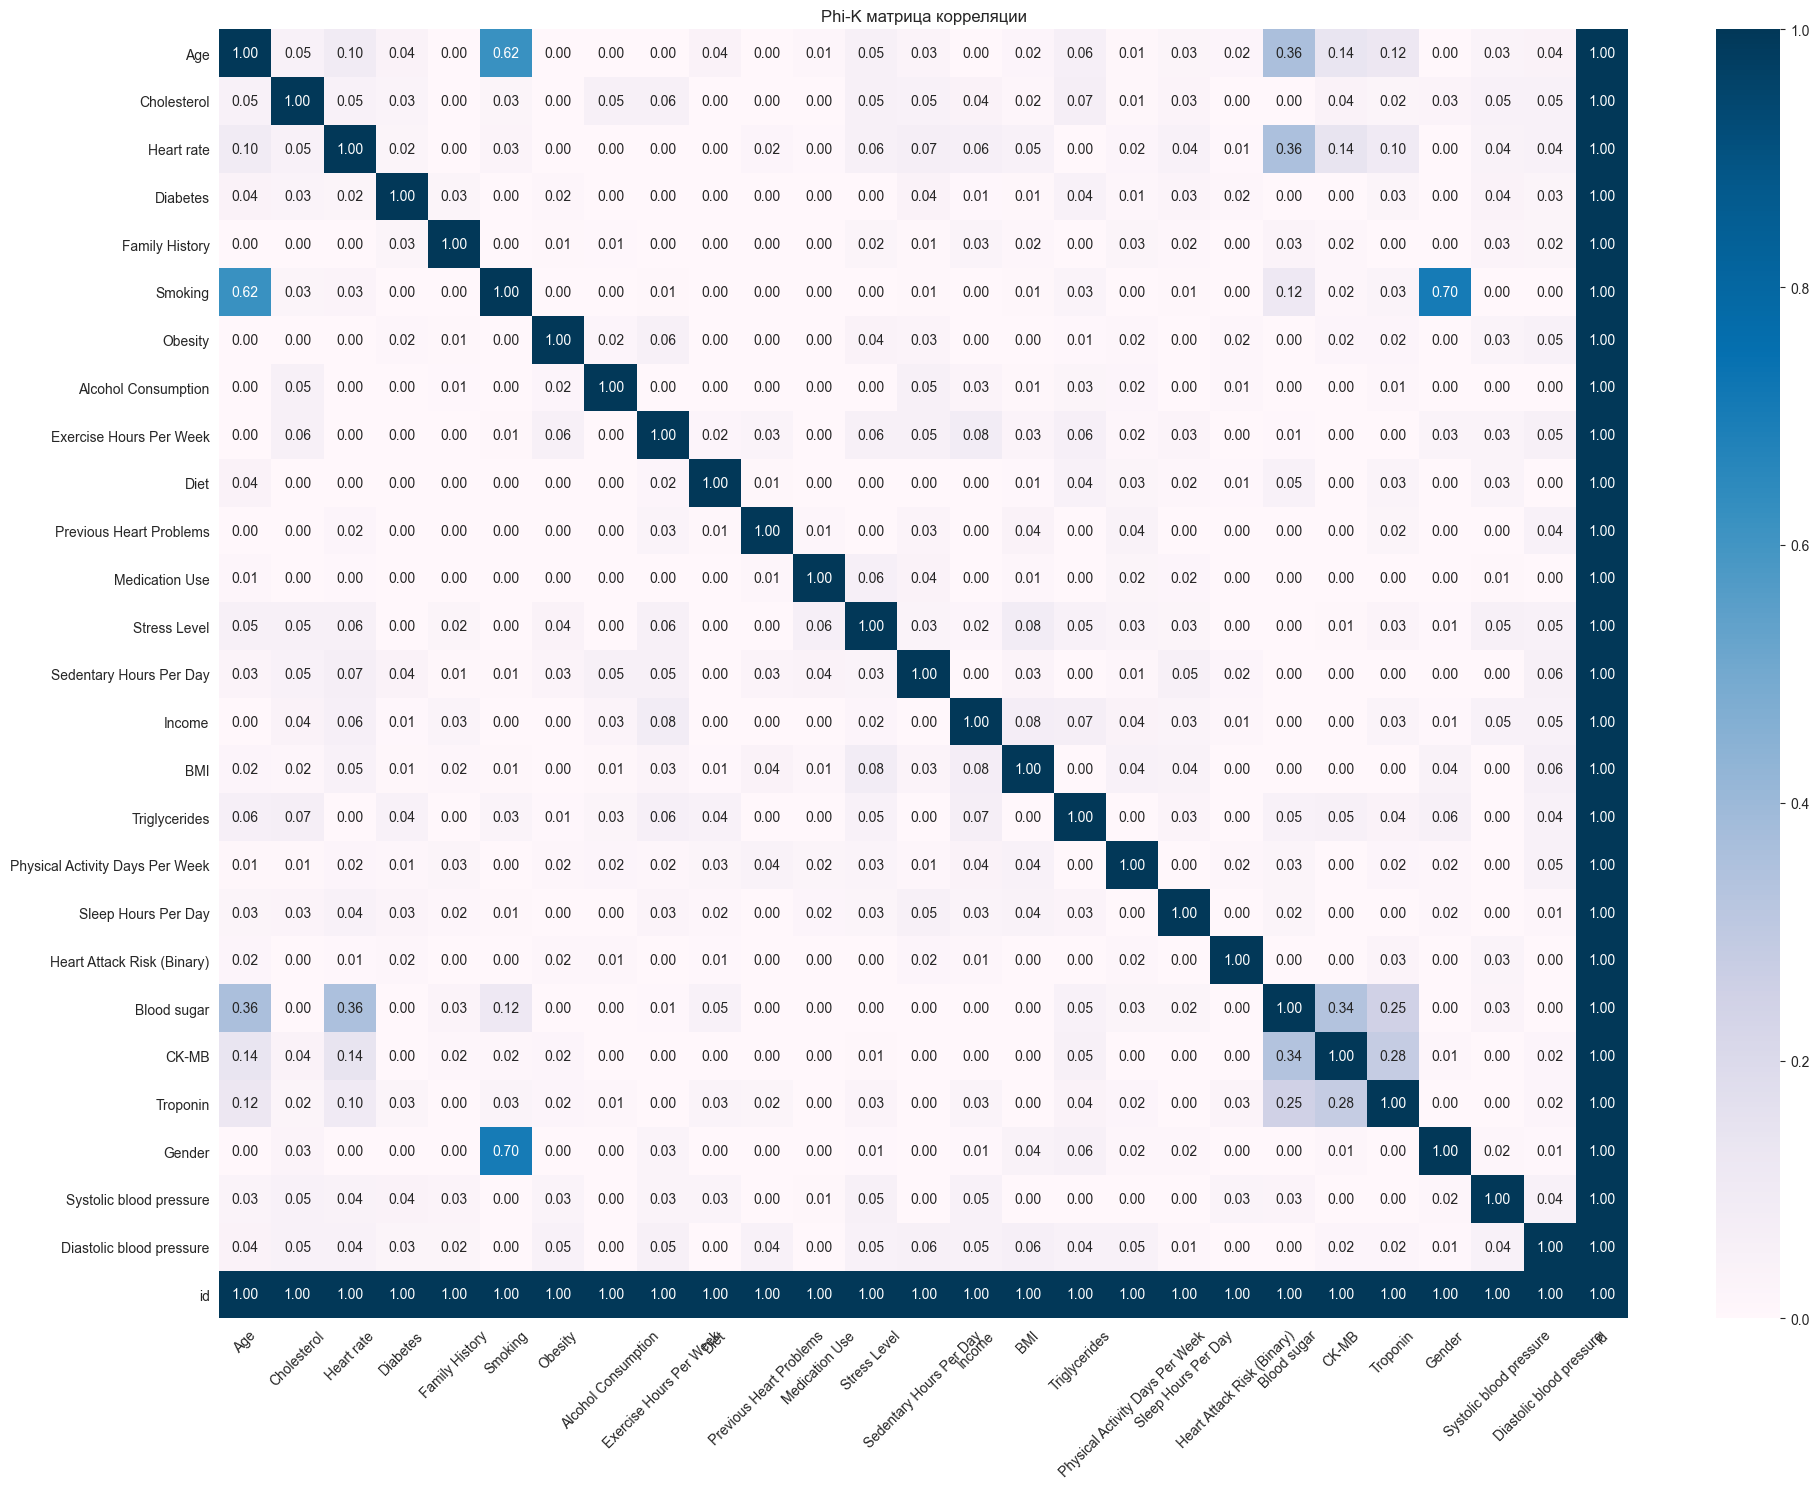

In [19]:
plt.figure(figsize=(20, 15))
phik_matrix = heart_train_cleaned.phik_matrix(interval_cols=num_cols)
sns.heatmap(phik_matrix, annot=True, cmap='PuBu', fmt=".2f")
plt.title('Phi-K матрица корреляции')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [20]:
phik_matrix = heart_train_cleaned.phik_matrix(interval_cols=num_cols)

# Преобразуем матрицу в DataFrame для удобства обработки
corr_df = pd.DataFrame(phik_matrix)
corr_df = corr_df.drop(columns=['id'], errors='ignore')  # Игнорируем ошибку, если столбца нет
corr_df = corr_df.drop(index=['id'], errors='ignore')  
# Создаем список для хранения ненулевых корреляций
correlations  = []

# Проходим по матрице и собираем ненулевые значения
for i in range(len(corr_df)):
    for j in range(i+1, len(corr_df)):  # Проверяем только верхний треугольник, чтобы избежать дублирования
        value = corr_df.iloc[i, j]
        if abs(value) > 0.1:  # Можно установить порог, например 0.01, чтобы отсечь очень слабые связи
            row_name = corr_df.index[i]
            col_name = corr_df.columns[j]
            correlations.append((row_name, col_name, value))
            
correlations_sorted = sorted(correlations, key=lambda x: abs(x[2]), reverse=True)
# Выводим результат
print("Ненулевые корреляции:")
for row, col, val in correlations_sorted:
    print(f"{row} - {col}: {val:.2f}")

K:\program\Anaconda\envs\practicum\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable id is large: 8442. Are you sure this is not an interval variable? Analysis for pairs of variables including id can be slow.
  warnings.warn(


Ненулевые корреляции:
Smoking - Gender: 0.70
Age - Smoking: 0.62
Age - Blood sugar: 0.36
Heart rate - Blood sugar: 0.36
Blood sugar - CK-MB: 0.34
CK-MB - Troponin: 0.28
Blood sugar - Troponin: 0.25
Heart rate - CK-MB: 0.14
Age - CK-MB: 0.14
Age - Troponin: 0.12
Smoking - Blood sugar: 0.12
Heart rate - Troponin: 0.10


Курение (Smoking) и Пол (Gender) наибольшая корреляция.
Далее Возраст (Age) и Курение (Smoking).

Рассмотрим зависимость курения и пола более подробно.

Таблица сопряженности Smoking vs Gender:
Gender      0     1
Smoking            
0         820     0
1        1740  5882


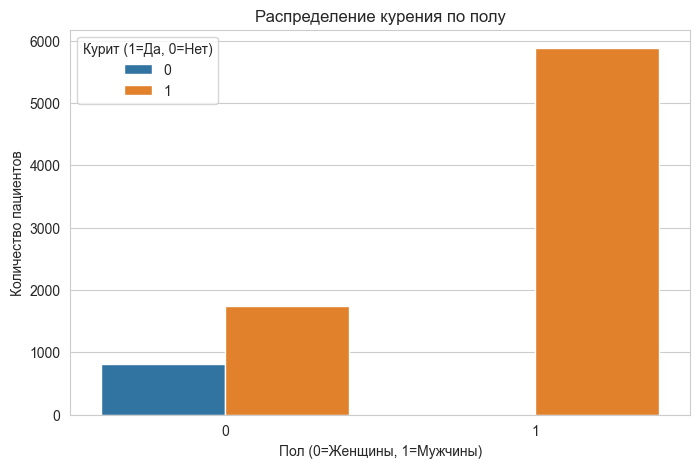

In [21]:
cross_tab = pd.crosstab(heart_train_cleaned['Smoking'], heart_train_cleaned['Gender'])
print("Таблица сопряженности Smoking vs Gender:")
print(cross_tab)

# Визуализация
plt.figure(figsize=(8, 5))
sns.countplot(data=heart_train_cleaned, x='Gender', hue='Smoking')
plt.title("Распределение курения по полу")
plt.xlabel("Пол (0=Женщины, 1=Мужчины)")
plt.ylabel("Количество пациентов")
plt.legend(title="Курит (1=Да, 0=Нет)")
plt.show()

# Проверим, как Smoking + Gender влияют на целевую переменную (например, HeartDisease)
if 'HeartDisease' in heart_train_cleaned.columns:
    plt.figure(figsize=(8, 5))
    sns.barplot(data=heart_train_cleaned, x='Gender', y='HeartDisease', hue='Smoking')
    plt.title("Влияние пола и курения на сердечные заболевания")
    plt.xlabel("Пол (0=Женщины, 1=Мужчины)")
    plt.ylabel("Вероятность болезни сердца")
    plt.legend(title="Курит (1=Да, 0=Нет)")
    plt.show()

Мужчины курят все, женщины больше половины.

А теперь рассмотрим еще зависимость от возраста, разбив на определенные возрастные группы.

C:\Users\Екатерина\AppData\Local\Temp\ipykernel_6396\3584295731.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heart_train_cleaned['AgeGroup'] = pd.cut(


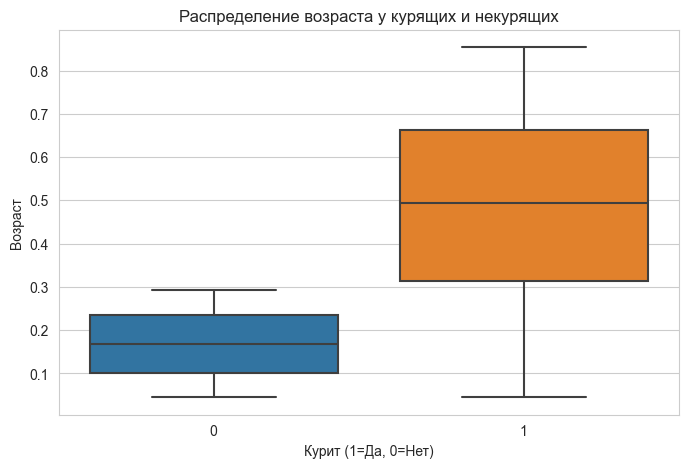

In [22]:
heart_train_cleaned['AgeGroup'] = pd.cut(
    heart_train_cleaned['Age'],
    bins=[20, 30, 40, 50, 60, 70, 100],
    labels=['20-30', '30-40', '40-50', '50-60', '60-70', '70+']
)

# Проверим средний возраст курящих vs некурящих
plt.figure(figsize=(8, 5))
sns.boxplot(data=heart_train_cleaned, x='Smoking', y='Age')
plt.title("Распределение возраста у курящих и некурящих")
plt.xlabel("Курит (1=Да, 0=Нет)")
plt.ylabel("Возраст")
plt.show()
heart_train_cleaned = heart_train_cleaned.drop('AgeGroup', axis=1)

Курящие люди наблюдаются преимущественно после 30.

Результаты VIF показывают очень низкий уровень мультиколлинеарности между переменными.

## 4. Обучение модели

Создадим pipeline и обучим следующие модели: KNeighborsClassifier, DecisionTreeClassifier, SVC и LogisticRegression.

In [23]:
target = 'Heart Attack Risk (Binary)'
features = [col for col in heart_train_cleaned.columns if col != target and col != 'id']

TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_valid, y_train, y_valid = train_test_split(
    heart_train_cleaned[features],
    heart_train_cleaned[target],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=heart_train_cleaned[target]
)

In [24]:
num_columns = [
    'Age', 'Cholesterol', 'Heart rate', 'Exercise Hours Per Week',
    'Diet', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI',
    'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day',
    'Blood sugar', 'CK-MB', 'Troponin', 'Systolic blood pressure',
    'Diastolic blood pressure'
]

cat_columns = [
    'Diabetes', 'Family History', 'Smoking', 'Obesity',
    'Alcohol Consumption', 'Previous Heart Problems',
    'Medication Use', 'Gender'
]

# Проверка, что все колонки существуют в данных
num_columns = list(set(num_columns) & set(features))
cat_columns = list(set(cat_columns) & set(features))

# Создание pipeline для числовых признаков
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    # Можно добавить масштабирование, например:
    # ('scaler', StandardScaler())
])

# Создание pipeline для категориальных признаков
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Объединение преобразований в ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipe, num_columns),
    ('cat', cat_pipe, cat_columns)
])

# Полный pipeline с feature selection
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('models', None)
])

In [25]:
param_distributions = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3, 25), 
        'models__weights': ['uniform', 'distance'],
        'models__p': [1, 2],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(3, 15),
        'models__min_samples_split': range(2, 10),
        'models__criterion': ['gini', 'entropy'],
        'preprocessor__num': ['passthrough'] 
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.1, 1, 10],
        'models__kernel': ['linear', 'rbf'],
        'models__gamma': ['scale', 'auto', 0.1, 1],
        'preprocessor__num': [StandardScaler()]
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)],
        'models__C': np.logspace(-3, 3, 7),
        'models__penalty': ['l1', 'l2'],
        'models__solver': ['liblinear', 'saga'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

# Настройки для RandomizedSearchCV
n_iter = 20  # Количество итераций для каждой модели
cv = 5       # Количество фолдов для кросс-валидации
scoring = 'roc_auc'  # Метрика для оптимизации

# Словарь для хранения результатов
results = {}

# Перебор всех конфигураций моделей
for params in param_distributions:
    model_name = params['models'][0].__class__.__name__
    print(f"\n=== Начинаем подбор параметров для {model_name} ===")
    
    # Инициализация RandomizedSearchCV
    search = RandomizedSearchCV(
        full_pipeline,
        param_distributions=params,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1
    )
    
    # Обучение модели
    search.fit(X_train, y_train)
    
    # Сохранение результатов
    results[model_name] = {
        'best_estimator': search.best_estimator_,
        'best_params': search.best_params_,
        'best_score': search.best_score_,
        'cv_results': search.cv_results_
    }
    
    # Вывод результатов
    print(f"Лучшие параметры для {model_name}:")
    print(search.best_params_)
    print(f"Лучший ROC-AUC: {search.best_score_:.4f}")
    
    # Оценка на валидационном наборе
    y_pred = search.predict(X_valid)
    y_proba = search.predict_proba(X_valid)[:, 1]
    
    print("\nClassification Report:")
    print(classification_report(y_valid, y_pred))
    print(f"ROC-AUC на валидации: {roc_auc_score(y_valid, y_proba):.4f}\n")


=== Начинаем подбор параметров для KNeighborsClassifier ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие параметры для KNeighborsClassifier:
{'preprocessor__num': MinMaxScaler(), 'models__weights': 'distance', 'models__p': 1, 'models__n_neighbors': 11, 'models': KNeighborsClassifier(n_neighbors=11, p=1, weights='distance')}
Лучший ROC-AUC: 0.5554

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.83      0.74      1086
           1       0.43      0.23      0.30       603

    accuracy                           0.62      1689
   macro avg       0.55      0.53      0.52      1689
weighted avg       0.58      0.62      0.58      1689

ROC-AUC на валидации: 0.5786


=== Начинаем подбор параметров для DecisionTreeClassifier ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие параметры для DecisionTreeClassifier:
{'preprocessor__num': 'passthrough', 'models__min_samples_split': 3, 'model

K:\program\Anaconda\envs\practicum\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
K:\program\Anaconda\envs\practicum\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
K:\program\Anaconda\envs\practicum\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
print("\n=== Сравнение всех моделей ===")
for model_name, res in results.items():
    print(f"{model_name}:")
    print(f"  Лучший ROC-AUC (CV): {res['best_score']:.4f}")
    valid_proba = res['best_estimator'].predict_proba(X_valid)[:, 1]
    print(f"  ROC-AUC (валидация): {roc_auc_score(y_valid, valid_proba):.4f}")
    print(f"  Параметры: {res['best_params']}\n")

# Выбор лучшей модели
best_model_name = max(results, key=lambda x: results[x]['best_score'])
best_model = results[best_model_name]['best_estimator']

print(f"\nЛучшая модель: {best_model_name} с ROC-AUC {results[best_model_name]['best_score']:.4f}")


=== Сравнение всех моделей ===
KNeighborsClassifier:
  Лучший ROC-AUC (CV): 0.5554
  ROC-AUC (валидация): 0.5786
  Параметры: {'preprocessor__num': MinMaxScaler(), 'models__weights': 'distance', 'models__p': 1, 'models__n_neighbors': 11, 'models': KNeighborsClassifier(n_neighbors=11, p=1, weights='distance')}

DecisionTreeClassifier:
  Лучший ROC-AUC (CV): 0.5245
  ROC-AUC (валидация): 0.5485
  Параметры: {'preprocessor__num': 'passthrough', 'models__min_samples_split': 3, 'models__max_depth': 13, 'models__criterion': 'entropy', 'models': DecisionTreeClassifier(criterion='entropy', max_depth=13, min_samples_split=3,
                       random_state=42)}

SVC:
  Лучший ROC-AUC (CV): 0.5435
  ROC-AUC (валидация): 0.5334
  Параметры: {'preprocessor__num': StandardScaler(), 'models__kernel': 'rbf', 'models__gamma': 1, 'models__C': 10, 'models': SVC(C=10, gamma=1, probability=True, random_state=42)}

LogisticRegression:
  Лучший ROC-AUC (CV): 0.5028
  ROC-AUC (валидация): 0.5184
  Парам

Оценим признаки.

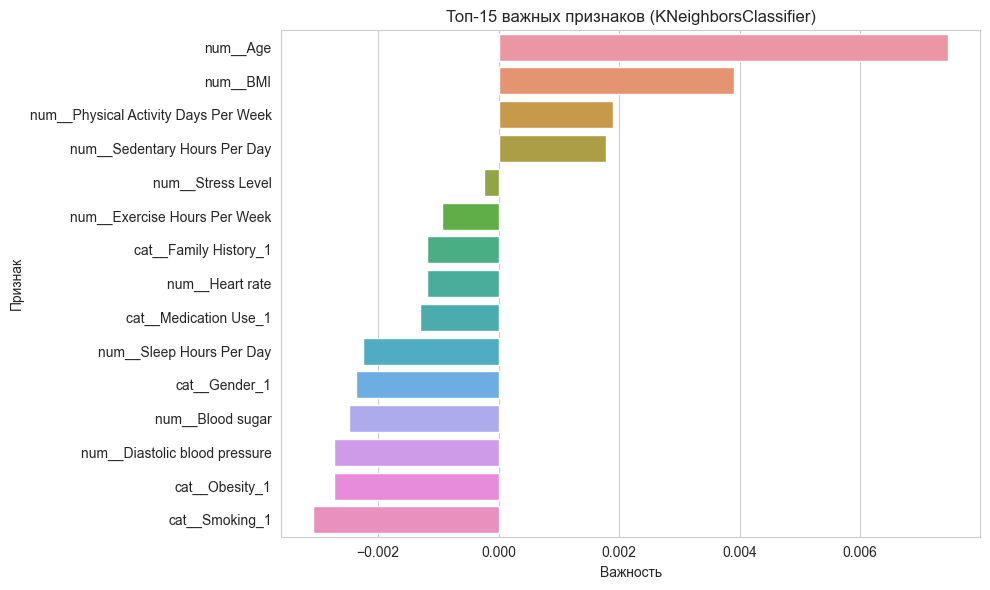

In [27]:
result = permutation_importance(
    best_model, 
    X_valid, 
    y_valid,
    n_repeats=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Получаем имена признаков после предобработки
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Проверяем, что длины совпадают
if len(feature_names) != len(result.importances_mean):
    print(f"Предупреждение: Несоответствие размеров ({len(feature_names)} признаков vs {len(result.importances_mean)} значений важности)")
    # Используем числовые индексы, если имена не совпадают
    feature_names = [f'признак_{i}' for i in range(len(result.importances_mean))]

# Создаем DataFrame
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность': result.importances_mean
}).sort_values('Важность', ascending=False)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x='Важность', y='Признак', data=importance_df.head(15))
plt.title(f'Топ-15 важных признаков ({best_model_name})')
plt.tight_layout()
plt.show()

Наиболее значимые признаки:

* артериальное давление
* триглицерин
* возраст
* доход

Попробуем подобрать порог.

Примеры порогов классификации:
      threshold  precision    recall
0      0.317460   0.357016  1.000000
1      0.321843   0.357227  1.000000
2      0.322240   0.357439  1.000000
3      0.322616   0.357651  1.000000
4      0.323310   0.357864  1.000000
1666   0.392587   0.400000  0.003317
1667   0.394278   0.500000  0.003317
1668   0.395465   0.333333  0.001658
1669   0.395502   0.500000  0.001658
1670   0.396097   0.000000  0.000000


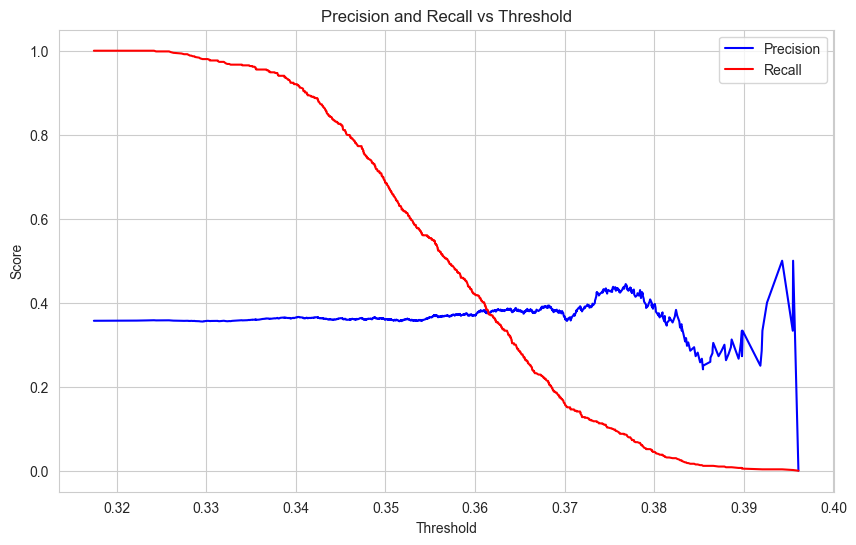


Оптимальный порог классификации: 0.362
Precision при этом пороге: 0.375
Recall при этом пороге: 0.375

Classification Report с оптимальным порогом:
              precision    recall  f1-score   support

           0       0.65      0.65      0.65      1086
           1       0.37      0.37      0.37       603

    accuracy                           0.55      1689
   macro avg       0.51      0.51      0.51      1689
weighted avg       0.55      0.55      0.55      1689



In [28]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_proba)

# Создаем DataFrame с метриками
pr_df = pd.DataFrame({
    'threshold': thresholds,
    'precision': precision[:-1],  # Исключаем последний элемент (он всегда 1)
    'recall': recall[:-1]         # Исключаем последний элемент (он всегда 0)
})

# Выводим первые 5 и последние 5 порогов для проверки
print("Примеры порогов классификации:")
print(pd.concat([pr_df.head(), pr_df.tail()]))

# Визуализация precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Находим оптимальный порог (по точке пересечения precision и recall)
optimal_idx = np.argmin(np.abs(precision[:-1] - recall[:-1]))
optimal_threshold = thresholds[optimal_idx]

print(f"\nОптимальный порог классификации: {optimal_threshold:.3f}")
print(f"Precision при этом пороге: {precision[optimal_idx]:.3f}")
print(f"Recall при этом пороге: {recall[optimal_idx]:.3f}")

# Применяем оптимальный порог для новых предсказаний
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

# Выводим отчет о классификации с новым порогом
print("\nClassification Report с оптимальным порогом:")
print(classification_report(y_valid, y_pred_optimal))

Посмтроим матрицу ошибок с оптимальным порогом.

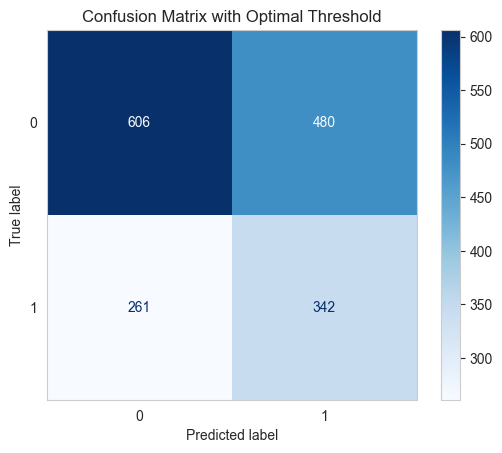

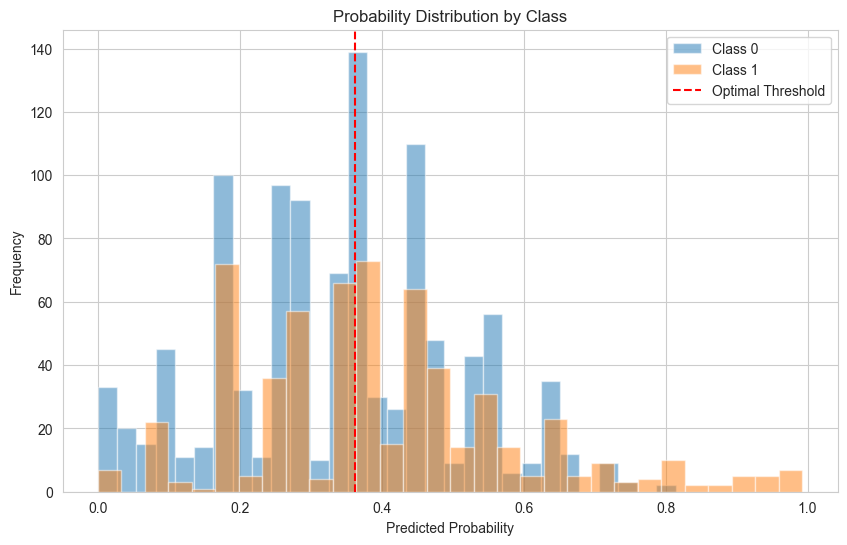

In [29]:
y_pred_optimal = (best_model.predict_proba(X_valid)[:, 1] >= 0.362).astype(int)

# Матрица ошибок
cm = confusion_matrix(y_valid, y_pred_optimal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix with Optimal Threshold')
plt.grid(False)
plt.show()

# Анализ распределения вероятностей
plt.figure(figsize=(10, 6))
plt.hist(best_model.predict_proba(X_valid)[y_valid==0, 1], bins=30, alpha=0.5, label='Class 0')
plt.hist(best_model.predict_proba(X_valid)[y_valid==1, 1], bins=30, alpha=0.5, label='Class 1')
plt.axvline(0.362, color='red', linestyle='--', label='Optimal Threshold')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.title('Probability Distribution by Class')
plt.show()

In [30]:
y_proba = best_model.predict_proba(X_valid)[:, 1]
y_pred_default = best_model.predict(X_valid)  # Порог 0.5 по умолчанию
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)  # Новый порог

# Создаем сравнительную таблицу для первых 20 примеров
compare_df = pd.DataFrame({
    'True Label': y_valid.values[:20],
    'Predicted Probability': y_proba[:20],
    'Prediction (threshold=0.5)': y_pred_default[:20],
    'Prediction (threshold={:.3f})'.format(optimal_threshold): y_pred_optimal[:20],
    'Changed': y_pred_default[:20] != y_pred_optimal[:20]
})

# Добавляем пояснение изменений
compare_df['Effect'] = compare_df.apply(lambda row: 
    'FP -> TP' if row['Changed'] and row['True Label'] == 1 else
    'FN -> TN' if row['Changed'] and row['True Label'] == 0 else
    'No change', axis=1)

# Форматируем вывод
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.3f}'.format)

print("\nСравнительная таблица предсказаний до и после изменения порога:")
print(compare_df)

# Статистика по изменениям
changed = (y_pred_default != y_pred_optimal).sum()
total = len(y_valid)
print(f"\nИзменения в предсказаниях: {changed} из {total} ({changed/total:.1%})")
print("FP -> TP: Ложный негатив стал истинным позитивом")
print("FN -> TN: Ложный позитив стал истинным негативом")


Сравнительная таблица предсказаний до и после изменения порога:
    True Label  Predicted Probability  Prediction (threshold=0.5)  Prediction (threshold=0.362)  Changed     Effect
0            0                  0.364                           0                             1     True   FN -> TN
1            0                  0.055                           0                             0    False  No change
2            0                  0.365                           0                             1     True   FN -> TN
3            0                  0.356                           0                             0    False  No change
4            0                  0.358                           0                             0    False  No change
5            0                  0.556                           1                             1    False  No change
6            1                  0.196                           0                             0    False  No change
7      

Теперь попробуем использовать модель CatBoostClassifier.

0:	learn: 0.6930535	test: 0.6930912	best: 0.6930912 (0)	total: 158ms	remaining: 7m 53s
100:	learn: 0.6858214	test: 0.6922039	best: 0.6921879 (99)	total: 1.25s	remaining: 36s
200:	learn: 0.6792077	test: 0.6911993	best: 0.6911993 (200)	total: 2.29s	remaining: 31.9s
300:	learn: 0.6730671	test: 0.6905167	best: 0.6904954 (299)	total: 3.42s	remaining: 30.7s
400:	learn: 0.6669763	test: 0.6896190	best: 0.6896091 (397)	total: 4.65s	remaining: 30.1s
500:	learn: 0.6612131	test: 0.6888048	best: 0.6887927 (499)	total: 5.51s	remaining: 27.5s
600:	learn: 0.6556851	test: 0.6882660	best: 0.6882124 (579)	total: 6.28s	remaining: 25.1s
700:	learn: 0.6501086	test: 0.6879589	best: 0.6879377 (696)	total: 6.96s	remaining: 22.8s
800:	learn: 0.6448529	test: 0.6875274	best: 0.6875274 (800)	total: 7.63s	remaining: 21s
900:	learn: 0.6392993	test: 0.6871782	best: 0.6871618 (895)	total: 8.2s	remaining: 19.1s
1000:	learn: 0.6341484	test: 0.6866614	best: 0.6866574 (998)	total: 8.73s	remaining: 17.4s
1100:	learn: 0.629

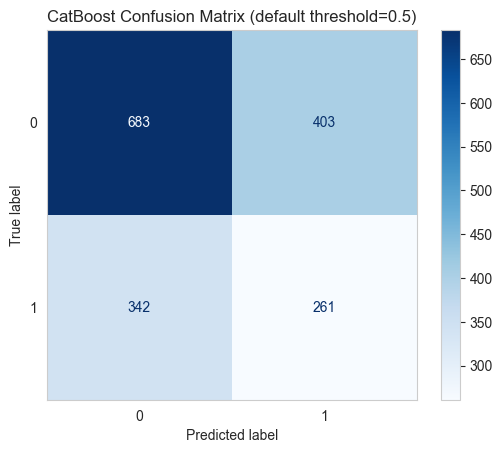


Optimal threshold for CatBoost: 0.505

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      1086
           1       0.40      0.40      0.40       603

    accuracy                           0.57      1689
   macro avg       0.53      0.53      0.53      1689
weighted avg       0.57      0.57      0.57      1689


=== Сравнение CatBoost с лучшей предыдущей моделью ===
Лучшая предыдущая модель: KNeighborsClassifier
Её ROC-AUC: 0.5554
CatBoost ROC-AUC: 0.5637


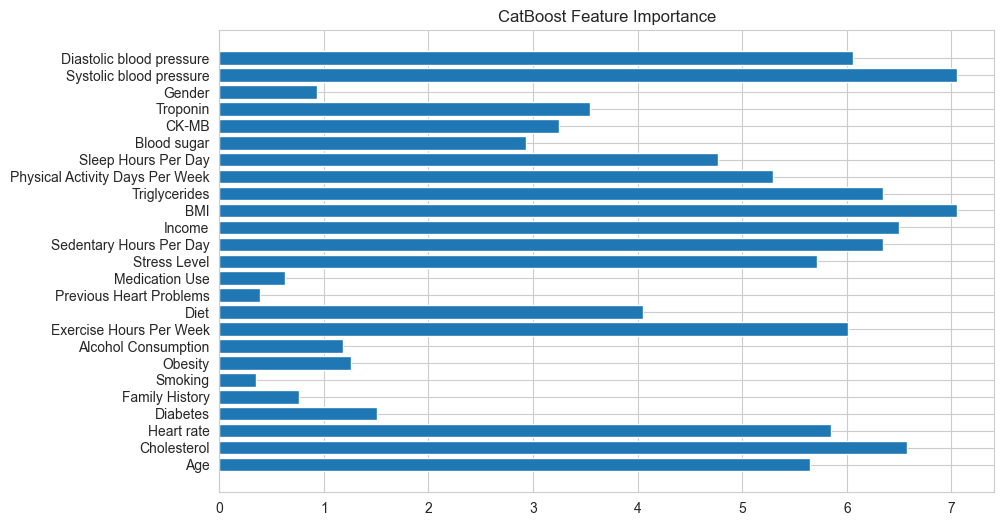

In [31]:
cat_features = list(set(cat_columns) & set(features))

# Инициализация CatBoostClassifier с подобранными параметрами
catboost_model = CatBoostClassifier(
    random_seed=RANDOM_STATE,
    iterations=3000,
    learning_rate=0.005,
    auto_class_weights='Balanced',
    custom_loss=['AUC', 'Recall', 'Accuracy'],
    verbose=100,  # Выводим информацию каждые 100 итераций
    early_stopping_rounds=100,
    task_type='CPU'  # Можно изменить на 'GPU' при наличии
)

# Обучение модели
catboost_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_valid, y_valid)
)

# Предсказания на валидационном наборе
y_pred_cat = catboost_model.predict(X_valid)
y_proba_cat = catboost_model.predict_proba(X_valid)[:, 1]

# Оценка качества
print("\n=== CatBoost Classification Report ===")
print(classification_report(y_valid, y_pred_cat))
print(f"ROC-AUC: {roc_auc_score(y_valid, y_proba_cat):.4f}")

# Матрица ошибок
cm = confusion_matrix(y_valid, y_pred_cat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('CatBoost Confusion Matrix (default threshold=0.5)')
plt.grid(False)
plt.show()

# Анализ порога (аналогично вашему подходу)
precision, recall, thresholds = precision_recall_curve(y_valid, y_proba_cat)
optimal_idx = np.argmin(np.abs(precision[:-1] - recall[:-1]))
optimal_threshold_cat = thresholds[optimal_idx]

print(f"\nOptimal threshold for CatBoost: {optimal_threshold_cat:.3f}")
y_pred_optimal_cat = (y_proba_cat >= optimal_threshold_cat).astype(int)

print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_valid, y_pred_optimal_cat))

# Сравнение с лучшей моделью из RandomizedSearchCV
print("\n=== Сравнение CatBoost с лучшей предыдущей моделью ===")
print(f"Лучшая предыдущая модель: {best_model_name}")
print(f"Её ROC-AUC: {results[best_model_name]['best_score']:.4f}")
print(f"CatBoost ROC-AUC: {roc_auc_score(y_valid, y_proba_cat):.4f}")

# Визуализация важности признаков
feature_importance = catboost_model.get_feature_importance()
feature_names = catboost_model.feature_names_
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.title('CatBoost Feature Importance')
plt.show()

И подобрать порог.

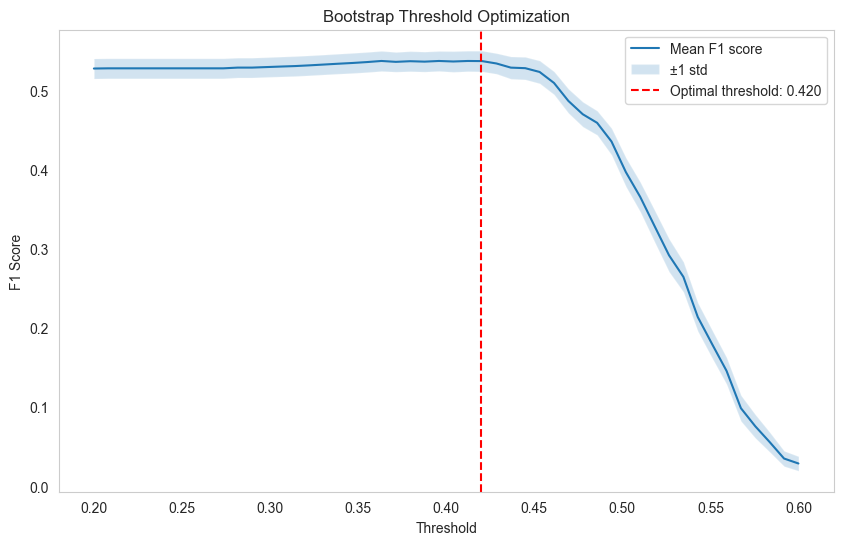


=== CatBoost с бутстрап-оптимизированным порогом ===
Оптимальный порог: 0.420
              precision    recall  f1-score   support

           0       0.79      0.13      0.22      1086
           1       0.37      0.94      0.53       603

    accuracy                           0.42      1689
   macro avg       0.58      0.53      0.38      1689
weighted avg       0.64      0.42      0.33      1689

ROC-AUC: 0.5637

Сравнение порогов:
- По умолчанию (0.5): F1 = 0.4120
- Через PR-кривую (0.505): F1 = 0.3964
- Бутстрап-оптимизированный (0.420): F1 = 0.5349


<Figure size 800x600 with 0 Axes>

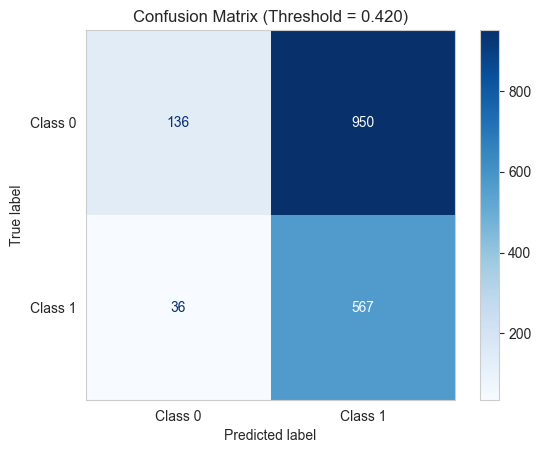


=== Метрики с оптимальным порогом ===
Оптимальный порог: 0.420
              precision    recall  f1-score   support

           0       0.79      0.13      0.22      1086
           1       0.37      0.94      0.53       603

    accuracy                           0.42      1689
   macro avg       0.58      0.53      0.38      1689
weighted avg       0.64      0.42      0.33      1689

ROC-AUC: 0.5637


In [32]:
n_bootstrap = 100  # Количество бутстрап-выборок
thresholds = np.linspace(0.2, 0.6, 50)  # Диапазон порогов для проверки
bootstrap_scores = []

# Бутстраппинг
for i in range(n_bootstrap):
    # Создаем бутстрап-выборку
    X_bs, y_bs = resample(X_valid, y_valid, random_state=RANDOM_STATE+i)
    
    # Предсказания вероятностей
    y_proba_bs = catboost_model.predict_proba(X_bs)[:, 1]
    
    # Вычисляем F1-скор для каждого порога (можно заменить на другую метрику)
    scores = []
    for thresh in thresholds:
        y_pred_bs = (y_proba_bs >= thresh).astype(int)
        scores.append(f1_score(y_bs, y_pred_bs))  # Используем F1 как компромисс между precision и recall
    
    bootstrap_scores.append(scores)

# Анализ результатов
bootstrap_scores = np.array(bootstrap_scores)
mean_scores = bootstrap_scores.mean(axis=0)
std_scores = bootstrap_scores.std(axis=0)

optimal_threshold_bootstrap = 0.42
# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(thresholds, mean_scores, label='Mean F1 score')
plt.fill_between(thresholds, 
                 mean_scores - std_scores, 
                 mean_scores + std_scores, 
                 alpha=0.2, label='±1 std')
plt.axvline(optimal_threshold_bootstrap, color='red', linestyle='--', 
            label=f'Optimal threshold: {optimal_threshold_bootstrap:.3f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Bootstrap Threshold Optimization')
plt.legend()
plt.grid()
plt.show()

# Применяем оптимальный порог
y_pred_bootstrap = (catboost_model.predict_proba(X_valid)[:, 1] >= optimal_threshold_bootstrap).astype(int)

# Оценка качества
print("\n=== CatBoost с бутстрап-оптимизированным порогом ===")
print(f"Оптимальный порог: {optimal_threshold_bootstrap:.3f}")
print(classification_report(y_valid, y_pred_bootstrap))
print(f"ROC-AUC: {roc_auc_score(y_valid, catboost_model.predict_proba(X_valid)[:, 1]):.4f}")

# Сравнение с предыдущими порогами
print("\nСравнение порогов:")
print(f"- По умолчанию (0.5): F1 = {f1_score(y_valid, y_pred_cat):.4f}")
print(f"- Через PR-кривую ({optimal_threshold_cat:.3f}): F1 = {f1_score(y_valid, y_pred_optimal_cat):.4f}")
print(f"- Бутстрап-оптимизированный ({optimal_threshold_bootstrap:.3f}): F1 = {f1_score(y_valid, y_pred_bootstrap):.4f}")

y_pred_bootstrap = (catboost_model.predict_proba(X_valid)[:, 1] >= optimal_threshold_bootstrap).astype(int)

# Строим матрицу ошибок
cm = confusion_matrix(y_valid, y_pred_bootstrap)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])

# Визуализация
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')  # 'd' для отображения целых чисел
plt.title(f'Confusion Matrix (Threshold = {optimal_threshold_bootstrap:.3f})')
plt.grid(False)
plt.show()

# Выводим метрики
print("\n=== Метрики с оптимальным порогом ===")
print(f"Оптимальный порог: {optimal_threshold_bootstrap:.3f}")
print(classification_report(y_valid, y_pred_bootstrap))
print(f"ROC-AUC: {roc_auc_score(y_valid, catboost_model.predict_proba(X_valid)[:, 1]):.4f}")

Сохраним модель в файл.

In [33]:
feature_names = X_train.columns.tolist()  # Все исходные колонки
cat_features = list(set(cat_columns) & set(feature_names))  # Только существующие категориальные признаки

final_threshold = optimal_threshold_bootstrap

catboost_model.save_model('catboost_model.cbm')

model_metadata = {
    'threshold': final_threshold,
    'cat_features': cat_features,  # Исходные имена категориальных колонок
    'feature_names': feature_names,  # Все исходные колонки (как в X_train)
    'optimal_threshold_info': {
        'value': float(optimal_threshold),
        'precision': float(precision[optimal_idx]),
        'recall': float(recall[optimal_idx])
    },
    'model_type': 'CatBoostClassifier',
    'training_params': {
        'iterations': 3000,
        'learning_rate': 0.005,
        'random_seed': RANDOM_STATE
    }
}

with open('catboost_metadata.pkl', 'wb') as f:
    pickle.dump(model_metadata, f)

print("Модель и метаданные успешно сохранены:")
print(f"- Модель: catboost_model.cbm")
print(f"- Метаданные: catboost_metadata.pkl")
print(f"\nКатегориальные признаки: {cat_features}")
print(f"Оптимальный порог: {final_threshold:.3f}")

Модель и метаданные успешно сохранены:
- Модель: catboost_model.cbm
- Метаданные: catboost_metadata.pkl

Категориальные признаки: ['Smoking', 'Alcohol Consumption', 'Obesity', 'Family History', 'Gender', 'Medication Use', 'Previous Heart Problems', 'Diabetes']
Оптимальный порог: 0.420


Тестовая выборка.

In [34]:
# Подготовка тестовых данных
for col in cat_columns:
    if col in heart_test_cleaned.columns:
        heart_test_cleaned[col] = heart_test_cleaned[col].astype(str)

# Выделяем фичи (исключаем 'id' и целевую переменную если есть)
X_test = heart_test_cleaned[features] 

# Функция для предсказания с порогом
def predict_with_threshold(model, X, threshold):
    proba = model.predict_proba(X)[:, 1]
    return (proba >= threshold).astype(int)

# Делаем предсказания с оптимальным порогом
y_test_pred = predict_with_threshold(catboost_model, X_test, optimal_threshold_bootstrap)

# Создаем DataFrame с предсказаниями в требуемом формате
predictions = pd.DataFrame({
    'id': heart_test_cleaned['id'],
    'prediction': y_test_pred
})

# Сохраняем результаты в CSV файл
predictions.to_csv('test_predictions.csv', index=False)

print("Предсказания успешно сохранены в файл 'test_predictions.csv'")
print("\nПример предсказаний (первые 5 строк):")
print(predictions.head())

Предсказания успешно сохранены в файл 'test_predictions.csv'

Пример предсказаний (первые 5 строк):
     id  prediction
0  7746           1
1  4202           1
2  6632           0
3  4639           1
4  4825           1


C:\Users\Екатерина\AppData\Local\Temp\ipykernel_6396\3403635624.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heart_test_cleaned[col] = heart_test_cleaned[col].astype(str)


# Вывод: 

Проект посвящен предсказанию сердечного риска у пациентов с использованием методов машинного обучения. Основные этапы работы включают:

* Исследование датасета.
* Предобработку данных.
* Обучение модели.
* Подготовку предсказаний на тестовой выборке.
* Загрузка данных

Данные содержат 27 признаков, включая возраст, уровень холестерина, наличие диабета, курение, физическую активность и другие медицинские показатели. 
Целевая переменная — Heart Attack Risk (Binary) (бинарный показатель риска сердечного приступа).
В бинарных столбцах были пропуски, которые были удалены.

При обучение модели ррименены различные алгоритмы машинного обучения:

* Логистическая регрессия (LogisticRegression)
* CatBoost (CatBoostClassifier)
* Метод k-ближайших соседей (KNeighborsClassifier)
* Метод опорных векторов (SVC) ...

В конечном итоге была выбрана модель CatBoostClassifier с порогом 0.420 ROC-AUC: 0.5637 и сохранена в файл. 